### Change log

#### Based on the input-2
#### 1. Extend the label from 3 types to 5 types
* Stable -> Stable
* Growth -> growth-exp  & growth-linear
* Decay -> decay-exp & decay-linear

### Load the train/test

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

ds_name = '02172021'
split_rs = '123'
ds_folder = f'../data/{ds_name}/split_rs{split_rs}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/02172021/split_rs123/test.csv
../data/02172021/split_rs123/train.csv
../data/02172021/split_rs123/test_edge.csv
../data/02172021/split_rs123/train_edge.csv


In [2]:
#Import the files
train_df = pd.read_csv(f'{ds_folder}/train.csv')
test_df = pd.read_csv(f'{ds_folder}/test.csv')

/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,4,16,19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
test_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm
118163,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118164,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118165,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118166,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118167,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remove the background nodes

In [4]:
train_df = train_df[train_df['cluster_id'] != 'Background']
test_df = test_df[test_df['cluster_id'] != 'Background']
print(f'Train: {train_df.shape}\nTest: {test_df.shape}')

Train: (74396, 47)
Test: (18628, 47)


In [5]:
test_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm
18623,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886
18624,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886
18625,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886
18626,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886
18627,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886


### Load the feature desciption

In [6]:
import json
js_f = osp.join('../aly/feat_dict.json')

with open(js_f, 'r') as f:
    feat_desc = json.load(f)

input_feat = feat_desc['norm_onehot_feats']
print(f'Inputs: {len(input_feat)}, {input_feat}')
label_feat = 'dynamic_cat'

label_map = feat_desc['dynamic']
label_map = {int(k): v for k, v in label_map.items()}
print(label_map)

Inputs: 21, ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'R0_cat_0', 'R0_cat_1', 'R0_cat_2', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']
{0: 'decay', 1: 'growth', 2: 'static'}


#### Replace the previous R0 (3 categories) with the normalized numerical R0 value.

In [7]:
rm_r0_cols = set(['R0_cat_0', 'R0_cat_1', 'R0_cat_2'])
input_feat = [feat for feat in input_feat if feat not in rm_r0_cols]
print(len(input_feat), input_feat)

18 ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']


#### Remove the negative R0 and normalize it
* Use the mean value of positive R0 in the **training** to replace all the negative R0 in the training and test
* Normalize the R0 

In [8]:
from sklearn import preprocessing

train_raw_r0 = np.reshape(train_df['R0'].values, (-1, 1))
test_raw_r0 = np.reshape(test_df['R0'].values, (-1, 1))

# negtive replacement for train
train_r0_neg_idx = train_raw_r0 <= 0
train_r0_pos_idx = train_raw_r0 > 0
avg_train_r0 = np.average(train_raw_r0[train_r0_pos_idx])

train_raw_r0[train_r0_neg_idx] = avg_train_r0

# neg replacement for test
test_r0_neg_idx = test_raw_r0 <= 0
test_raw_r0[test_r0_neg_idx] = avg_train_r0

In [9]:
train_df['R0'].describe()

count    74396.000000
mean         1.774971
std          0.847471
min          0.000216
25%          1.440777
50%          1.774971
75%          1.890583
max          6.709768
Name: R0, dtype: float64

In [10]:
# Standardization non-category features
r0_norm_col = 'R0-norm'
std_scaler = preprocessing.StandardScaler().fit(train_raw_r0)
norm_train_vals = std_scaler.transform(train_raw_r0)

norm_train_node_df = pd.DataFrame(norm_train_vals, columns=[r0_norm_col], index=train_df.index)
train_df = pd.concat([train_df, norm_train_node_df], axis=1)

train_df[r0_norm_col].describe()

count    7.439600e+04
mean     5.195646e-16
std      1.000007e+00
min     -2.094191e+00
25%     -3.943451e-01
50%      5.240204e-16
75%      1.364208e-01
max      5.823007e+00
Name: R0-norm, dtype: float64

In [11]:
norm_test_vals = std_scaler.transform(test_raw_r0)
norm_test_df = pd.DataFrame(norm_test_vals, columns=[r0_norm_col], index=test_df.index)
test_df = pd.concat([test_df, norm_test_df], axis=1)

test_df[r0_norm_col].describe()

count    1.862800e+04
mean     4.001491e-02
std      1.115532e+00
min     -2.088109e+00
25%     -5.447101e-01
50%      5.240204e-16
75%      2.816876e-01
max      5.412595e+00
Name: R0-norm, dtype: float64

In [12]:
input_feat += [r0_norm_col]

### Extend the label

In [23]:
x_train = train_df[input_feat]
dynamic_train = train_df['dynamic']
dynamic_model_train = train_df['dynamic_model']
treeid_train = train_df['sim']

x_test = test_df[input_feat]
dynamic_test = test_df['dynamic']
dynamic_model_test = test_df['dynamic_model']
treeid_test = test_df['sim']

In [24]:
np.unique(dynamic_model_test.values)

array(['exp', 'lin', 'stable'], dtype=object)

In [25]:
extend_labels = set()
for dynamic, dynamic_model in zip(dynamic_train.values, dynamic_model_train.values):
    extend_labels.add(f'{dynamic}-{dynamic_model}')
print(extend_labels)

{'static-stable', 'growth-lin', 'decay-lin', 'growth-exp', 'decay-exp'}


In [26]:
label_map

{0: 'decay', 1: 'growth', 2: 'static'}

In [65]:
extend_label_map = {extend_label: i for i, extend_label in enumerate(sorted(list(extend_labels)))}
print(extend_label_map)
extend_rvs_label_map = {num: name for name, num in extend_label_map.items()}
print(extend_rvs_label_map)
feat_desc['extend_dynamic'] = extend_rvs_label_map

{'decay-exp': 0, 'decay-lin': 1, 'growth-exp': 2, 'growth-lin': 3, 'static-stable': 4}
{0: 'decay-exp', 1: 'decay-lin', 2: 'growth-exp', 3: 'growth-lin', 4: 'static-stable'}


In [34]:
y_train_lst, y_test_lst = [], []
for dynamic, dynamic_model in zip(dynamic_train.values, dynamic_model_train.values):
    y_train_lst.append(extend_label_map[f'{dynamic}-{dynamic_model}'])

for dynamic, dynamic_model in zip(dynamic_test.values, dynamic_model_test.values):
    y_test_lst.append(extend_label_map[f'{dynamic}-{dynamic_model}'])

y_train = pd.Series(y_train_lst)
y_test = pd.Series(y_test_lst)
y_train

0        4
1        4
2        4
3        4
4        4
        ..
74391    4
74392    4
74393    4
74394    4
74395    4
Length: 74396, dtype: int64

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>,
        <AxesSubplot:title={'center':'oster-norm'}>],
       [<AxesSubplot:title={'center':'birth_rate-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>,
        <AxesSubplot:title={'center':'fraction_time_growth-norm'}>],
       [<AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_0'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_1'}>],
       [<AxesSubplot:title={'center':'ltt_shape_cat_2'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_3'}>,
        <AxesSubplot:title={'center':'gamma_cat_0'}>,
        <AxesSubplot:title={'center':'gamma_cat_1'}>],
       [<AxesSubplot:title={'center':'gamma_cat_2'}>,
        <AxesS

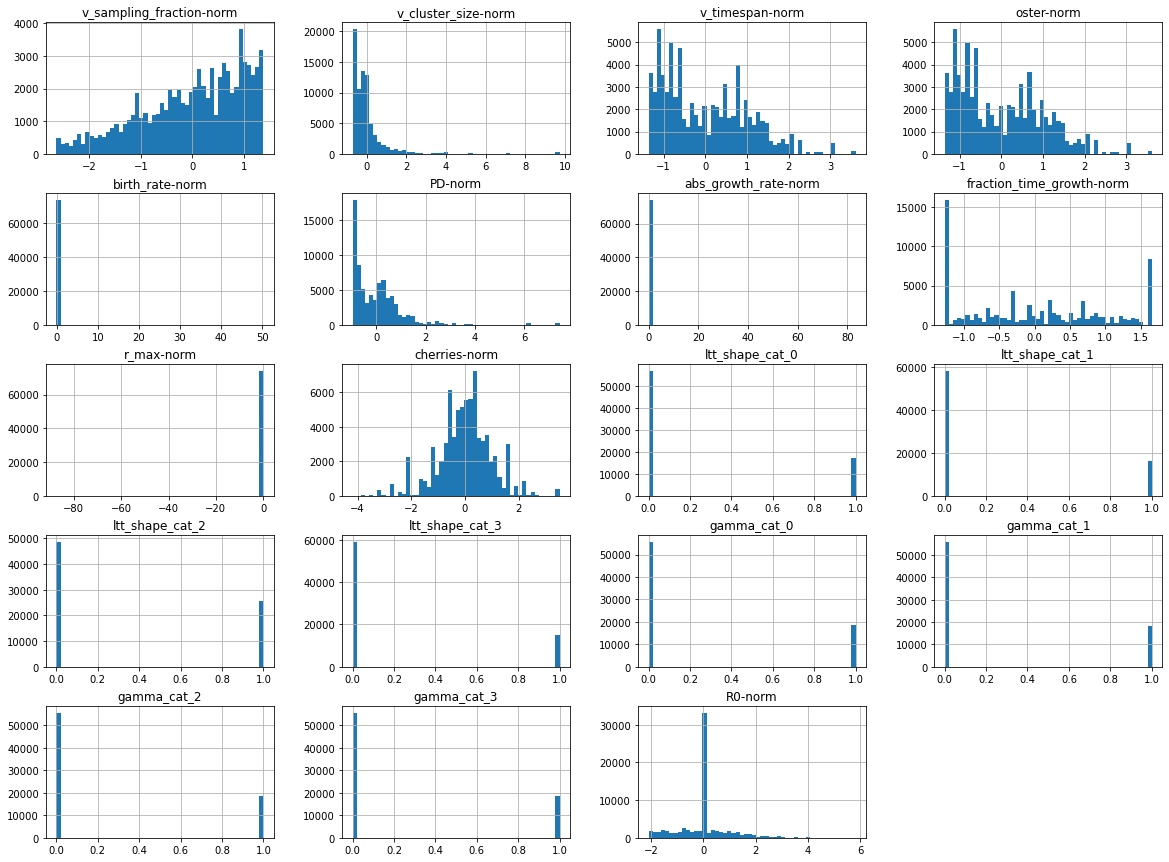

In [35]:
x_train.hist(bins=50,figsize=(20,15))

### Label distribution

['decay-exp', 'decay-lin', 'growth-exp', 'growth-lin', 'static-stable']
Train:
4    73.037529
1     9.437335
0     8.134846
2     7.548793
3     1.841497
dtype: float64

Test:
4    73.062057
1     9.458879
2     9.002577
0     6.919691
3     1.556796
dtype: float64



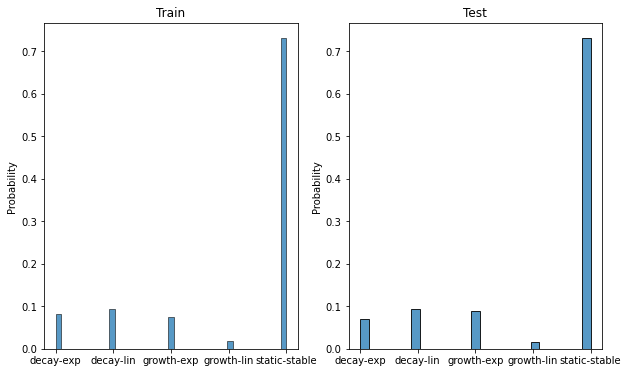

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
n_class = len(extend_label_map)
extend_label_lst = [extend_rvs_label_map[i] for i in range(n_class)]
print(extend_label_lst)

for i, (title, label_df) in enumerate(zip(['Train', 'Test'], [y_train, y_test])): 
    sns.histplot(label_df, bins='auto', stat="probability", ax=axs[i])
    axs[i].set_xticks([i for i in range(n_class)])
    axs[i].set_xticklabels(extend_label_lst)
    axs[i].set_title(title)
    print(f'{title}:\n{label_df.value_counts(normalize=True) * 100}\n')

In [46]:
y_test.head()

0    4
1    4
2    4
3    4
4    4
dtype: int64

### SMOTE and RandomOverSampler for resampling the imbalanced data

#### Get the cat features which is used for SMOTENC

In [47]:
import re

col_names = list(x_train.columns)
cat_patterns = ['ltt_shape_cat_\d*', 'gamma_cat_\d']
cat_cols_ids = []

for pattern in cat_patterns:
    for col in col_names:
        m = re.match(pattern, col)
        if m:
            idx = col_names.index(m.group(0))
            cat_cols_ids.append(idx)
            print(col_names[idx])

ltt_shape_cat_0
ltt_shape_cat_1
ltt_shape_cat_2
ltt_shape_cat_3
gamma_cat_0
gamma_cat_1
gamma_cat_2
gamma_cat_3


In [48]:
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from collections import Counter
np.random.seed(0)

train_data_dict = dict()
treeid_col_idx = x_train.shape[1]  # Add the sim col to the end of the trian_df
cat_cols_ids += [treeid_col_idx]

sampler_dict = {
    'org': None,
    'ros': RandomOverSampler(random_state=0, shrinkage=0.1), 
    'smotenc': SMOTENC(categorical_features=cat_cols_ids, sampling_strategy='not majority', random_state=0, k_neighbors=5)
}

for sampler_name, sampler in sampler_dict.items():
    if sampler_name == 'org':
        x_train_res, y_train_res = x_train, y_train
        treeid_train = treeid_train
    elif sampler_name in ['ros', 'smotenc']:
        x_train_with_sim = pd.concat([x_train, train_df['sim']], axis=1)
        x_train_with_sim_res, y_train_res = sampler.fit_resample(x_train_with_sim, y_train)
        
        x_train_res = x_train_with_sim_res.iloc[:, :treeid_col_idx]
        treeid_train = x_train_with_sim_res['sim']
    
    train_data_dict[sampler_name] = [x_train_res, y_train_res, treeid_train]
    print(sorted(Counter(y_train_res).items()))

[(0, 6052), (1, 7021), (2, 5616), (3, 1370), (4, 54337)]
[(0, 54337), (1, 54337), (2, 54337), (3, 54337), (4, 54337)]
[(0, 54337), (1, 54337), (2, 54337), (3, 54337), (4, 54337)]


### t-SNE plot

Not saved! The t-SNE feature file has already exited. /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input3/tsne/org/train.npy
   label   t-SNE-1    t-SNE-2
0      4 -4.308499  51.432384
1      4 -4.308499  51.432384
2      4 -4.308499  51.432384
3      4 -4.308499  51.432384
4      4 -4.308499  51.432384
('4', '3', '2', '1', '0')


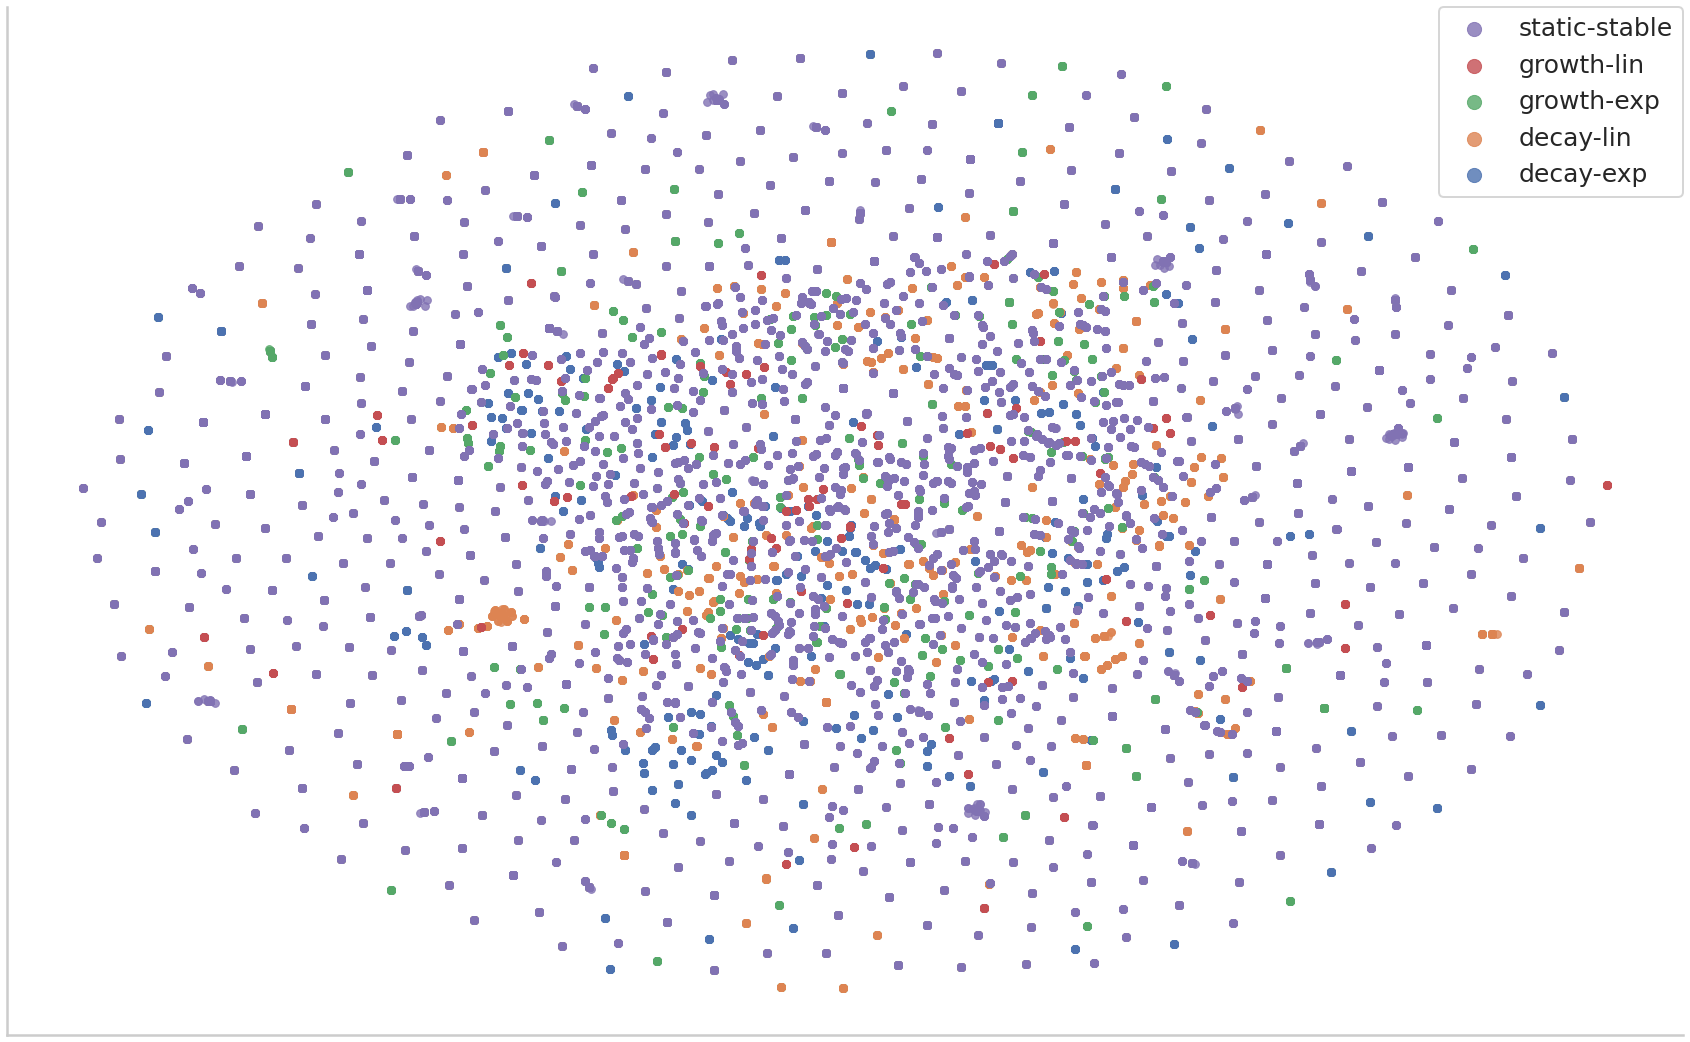

Not saved! The figure /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input3/tsne/org/train.png.png has already existed.
train is done.
   label   t-SNE-1    t-SNE-2
0      4  1.037473  33.090782
1      4  1.037473  33.090782
2      4  1.037473  33.090782
3      4  1.037473  33.090782
4      4  1.037473  33.090782
('4', '3', '2', '1', '0')


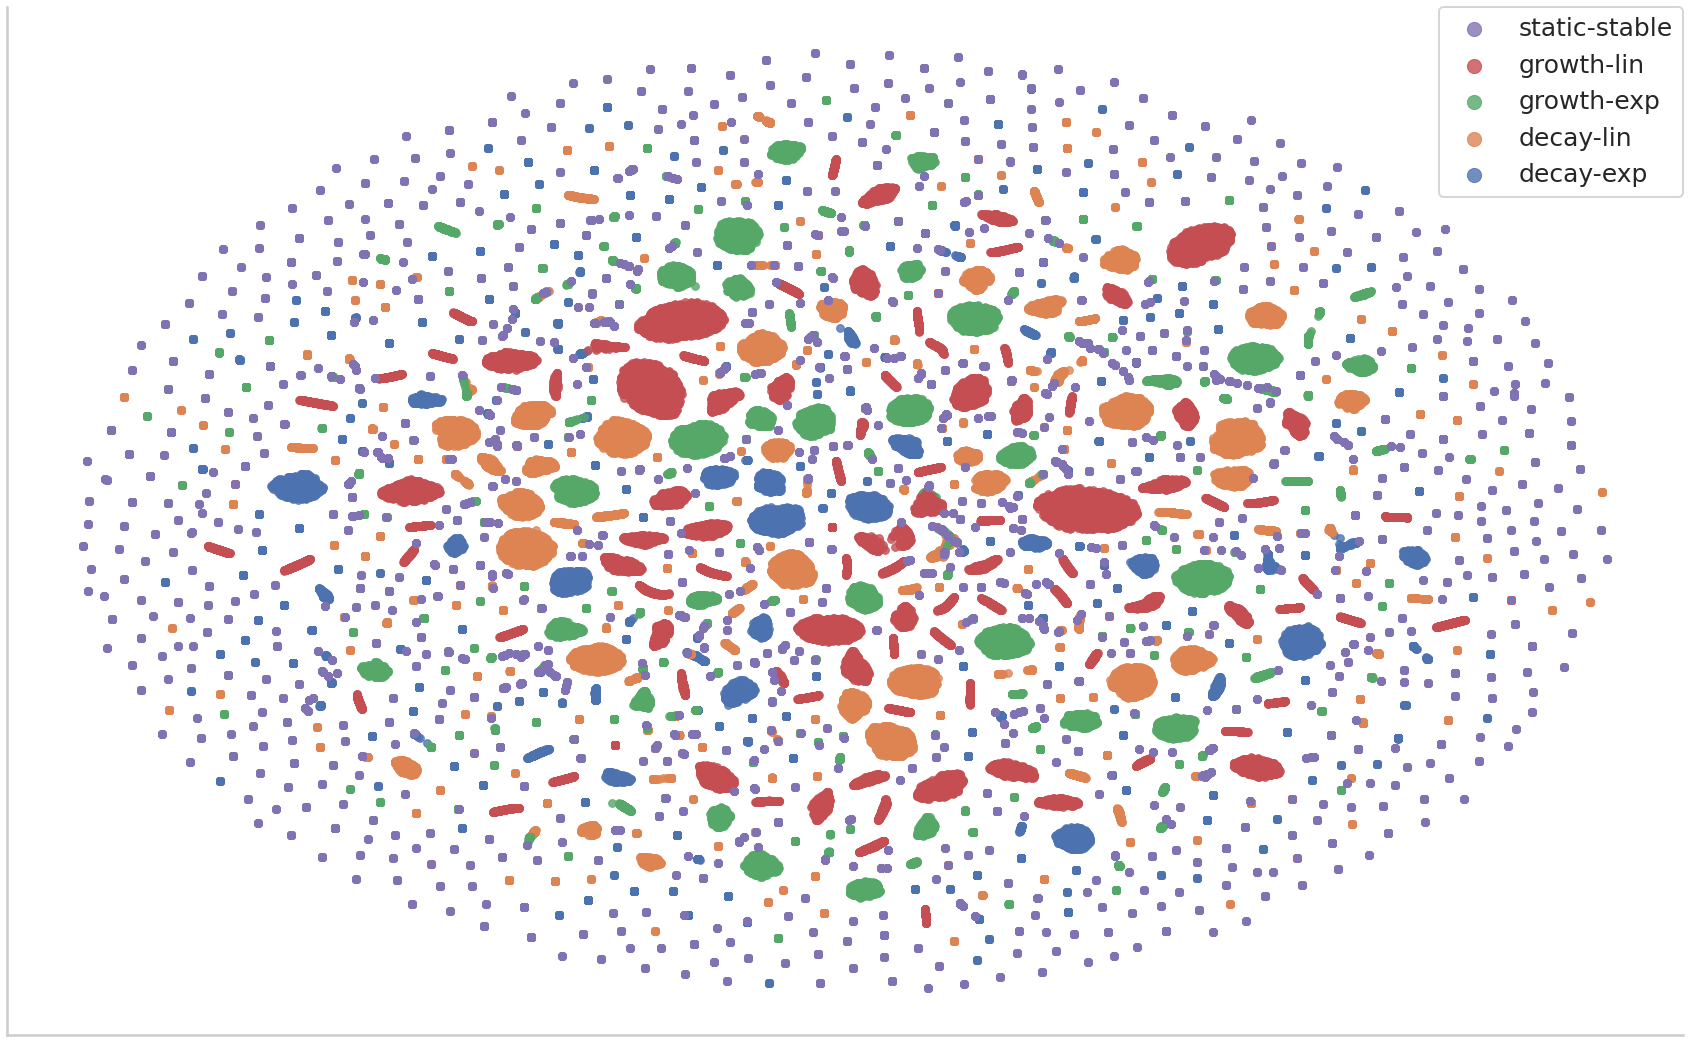

Save the plot /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input3/tsne/ros/train.png
train is done.
   label   t-SNE-1    t-SNE-2
0      4 -2.019158  32.989445
1      4 -2.019158  32.989445
2      4 -2.019158  32.989445
3      4 -2.019158  32.989445
4      4 -2.019158  32.989445
('4', '3', '2', '1', '0')


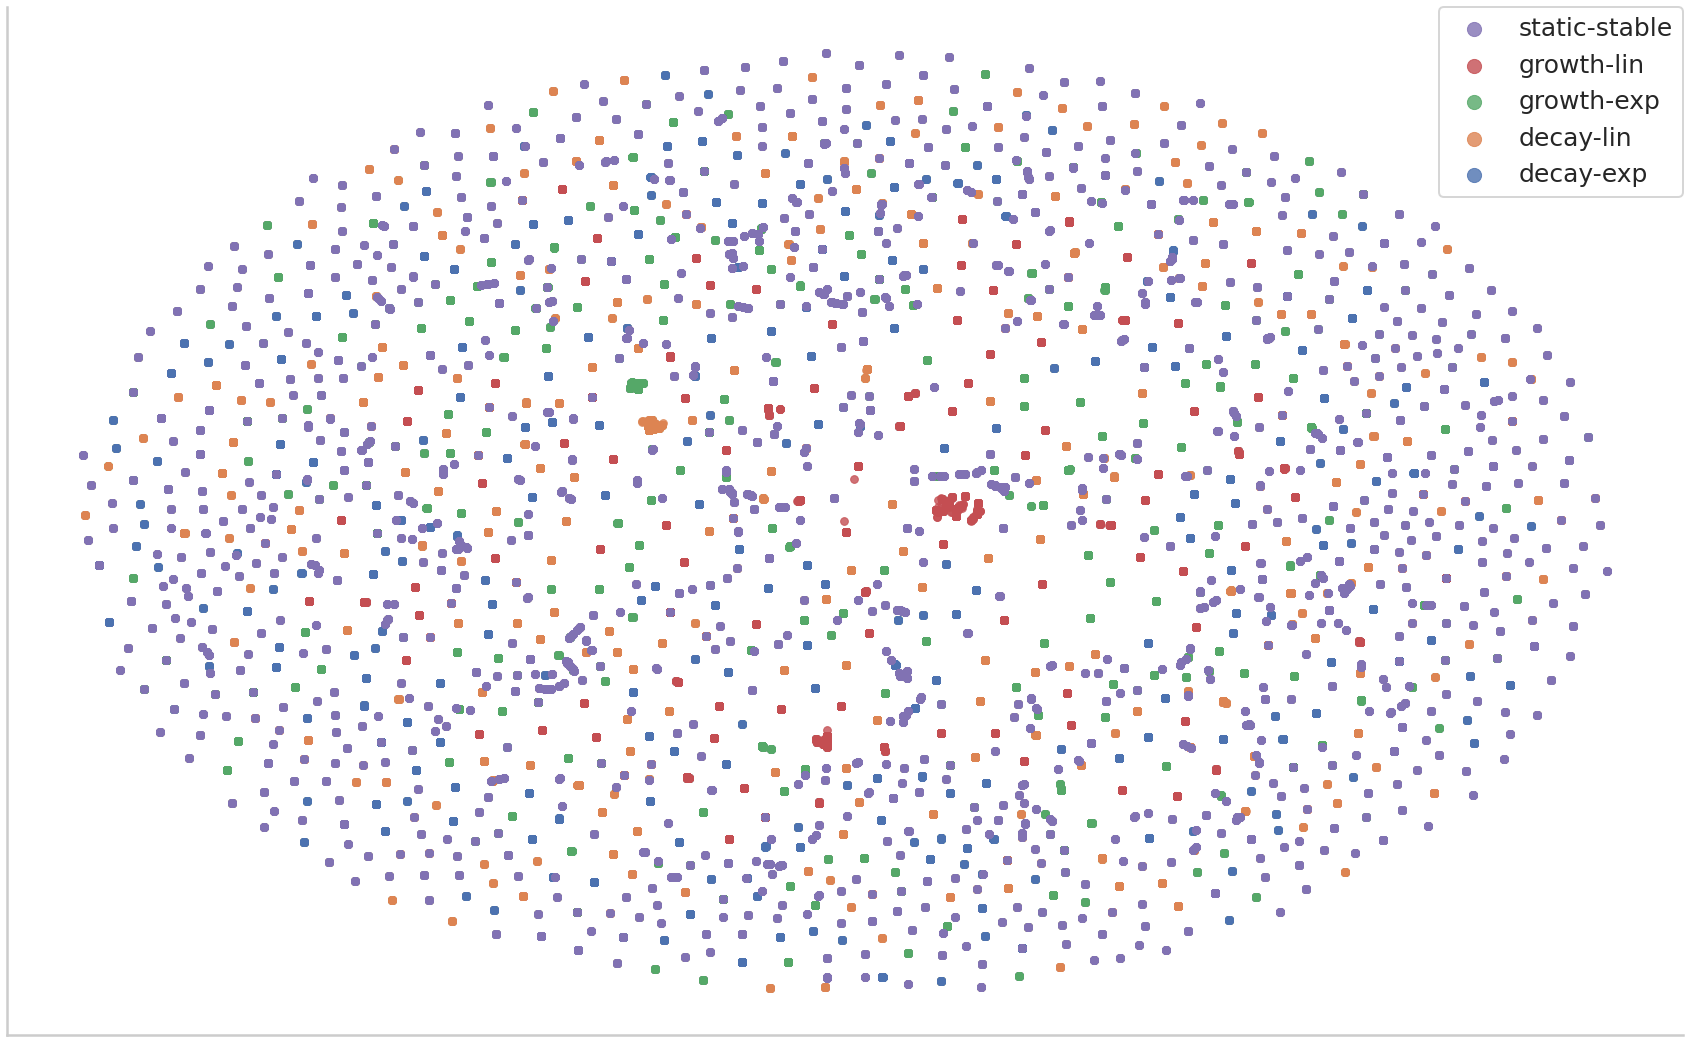

Save the plot /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input3/tsne/smotenc/train.png


In [54]:
from tsne import AlyTSNE
legend_info = deepcopy(extend_rvs_label_map)
tsne_folder = f'/data/yanjun/DeepPhyTree/checkpoints/{ds_name}/split_rs{split_rs}/models_norm_input3/tsne'
os.makedirs(tsne_folder, exist_ok=True)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    if sampler_name == 'org':
        aly_train_tsne = AlyTSNE(feat=x_train_res.values, label=y_train_res.values, subset='train', save_folder=f'{tsne_folder}/{sampler_name}')
        aly_train_tsne.generate_tsne(overwrite=False)
    else:
        aly_train_tsne = AlyTSNE(feat=x_train_res.values, label=y_train_res.values, subset='train', save_folder=f'{tsne_folder}/{sampler_name}')
        aly_train_tsne.generate_tsne(overwrite=False)
    aly_train_tsne.plot(legend_info=legend_info)

test is done.
   label    t-SNE-1     t-SNE-2
0      4 -14.353122  107.176544
1      4 -14.353122  107.176544
2      4 -14.353122  107.176544
3      4 -14.353122  107.176544
4      4 -14.353122  107.176544
('4', '3', '2', '1', '0')


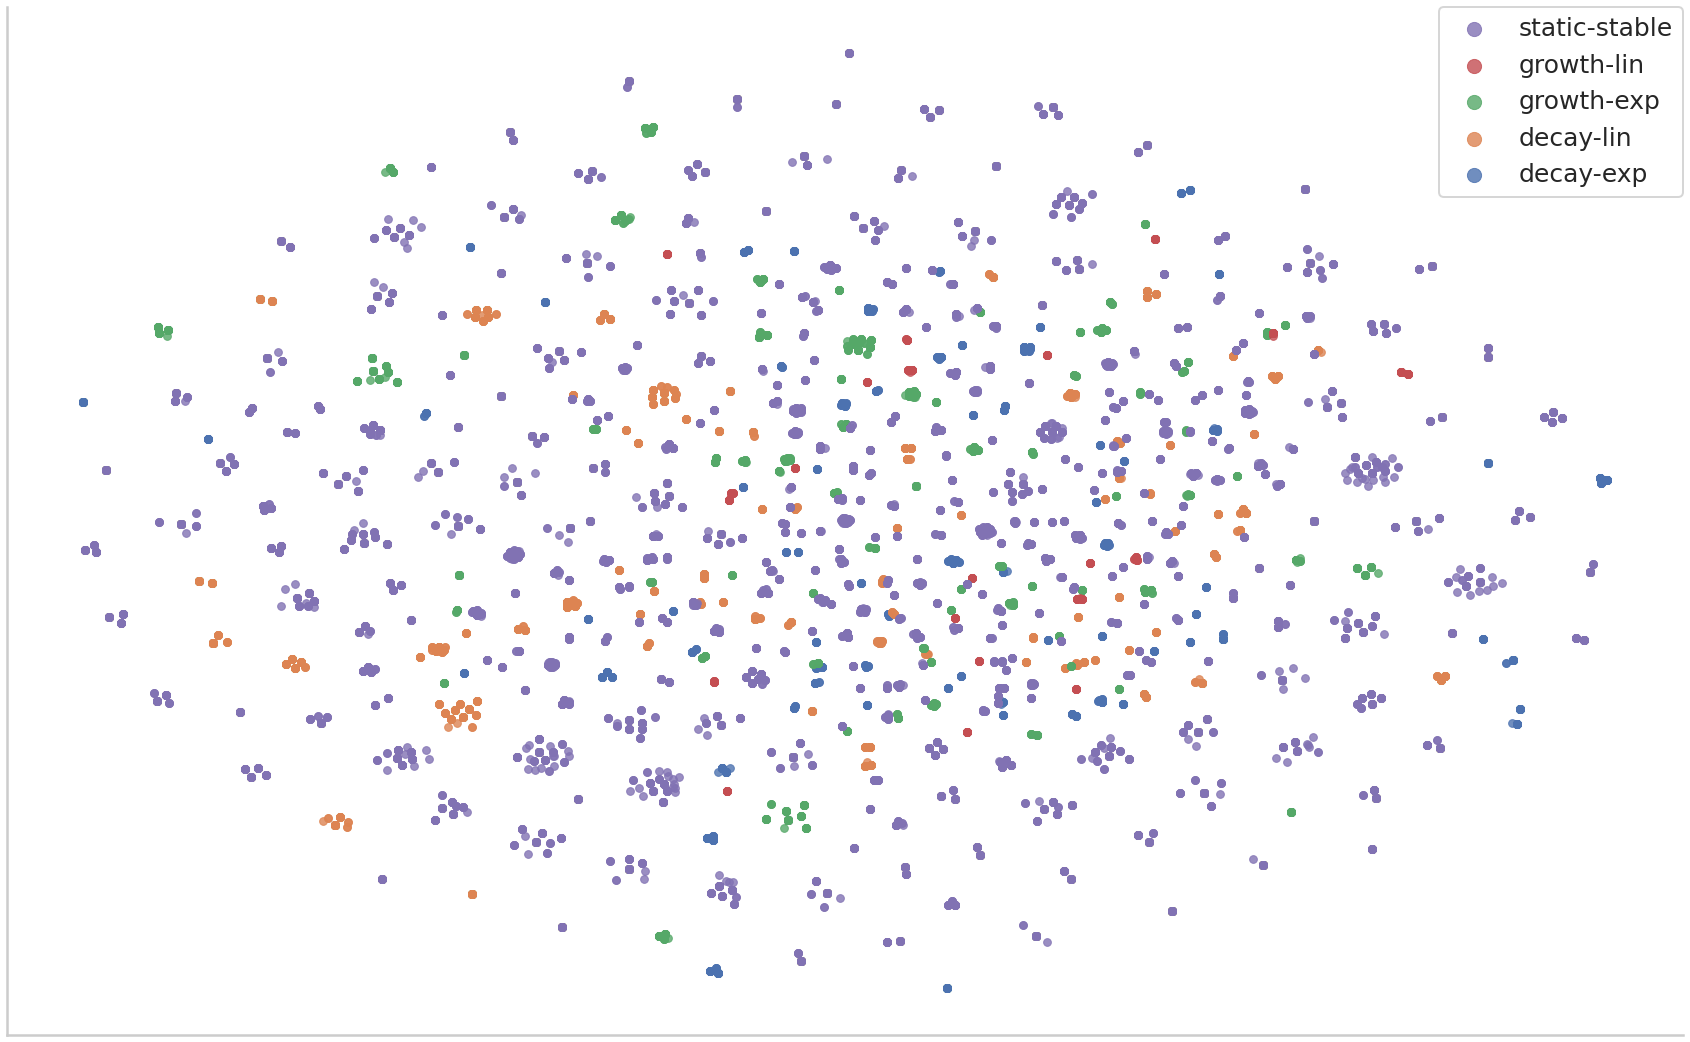

Save the plot /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input3/tsne/org/test.png


In [55]:
aly_test_tsne = AlyTSNE(feat=x_test.values, label=y_test.values, subset='test', save_folder=f'{tsne_folder}/org')
aly_test_tsne.generate_tsne(overwrite=False)
aly_test_tsne.plot(legend_info=legend_info)

### Cross-validation 

In [56]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, GroupKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score

n_folds = 5
print(f"CV: {n_folds}")

monitor_metric = None # 'f1_weighted'  # balanced_accuracy

# Set a seed for results reproduction
np.random.seed(0)

# Apply cross validation to select the best hyperparameters
# Note: cross validation split should work on the tree id, not node id.
# Incorrect: kf = KFold(n_folds,shuffle=True).split(x)

def cv_train(model, x, y, treeids):
    # TODO: verify the the groups for x
    gkf = GroupKFold(n_splits=5).split(x, groups=treeids)
    cv_val = cross_val_score(model, x, y, scoring=monitor_metric, cv=gkf)
    if not monitor_metric:
        return np.mean(cv_val), 'loss'
    return np.mean(cv_val), monitor_metric

CV: 5


In [57]:
model_folder = f'/data/yanjun/DeepPhyTree/checkpoints/{ds_name}/split_rs{split_rs}/models_norm_input2'
os.makedirs(model_folder, exist_ok=True)

In [72]:
label_encode_dict

{0: 'decay-exp',
 1: 'decay-lin',
 2: 'growth-exp',
 3: 'growth-lin',
 4: 'static-stable'}

In [98]:
# Onehot the label
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_auc_score, roc_curve

classes = np.unique(y_train)
n_classes = len(classes)
label_encode_dict = {str(k): v for k, v in feat_desc['extend_dynamic'].items()}

y_test_onehot = label_binarize(y_test, classes=classes)
            
def get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore):    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_predscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    # Micro-average: Calculate metrics globally by considering each element of the label indicator matrix as a label.
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_test_predscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

def plot_roc(n_classes, fpr, tpr, roc_auc):
    fig, axs = plt.subplots(2, 3, figsize=(27, 20))
    lw = 2

    for i, class_id in enumerate(range(n_classes)):
        row, col = np.unravel_index(i, (2, 3))
        ax = axs[row][col]
        ax.plot(fpr[class_id], tpr[class_id], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_id])
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=25)
        ax.set_ylabel('True Positive Rate', fontsize=25)
        if i != 0:
            ax.set_ylabel('')
        ax.set_title(f'ROC for {label_encode_dict[str(class_id)]}-{class_id}')
        ax.legend(loc="lower right")
    plt.show()    
        
def cal_auc(y_test_onehot, y_test_predscore, metric_dict):
    macro_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                  average="macro")
    # 'weighted': Calculate metrics for each label, and find their average, 
    # weighted by support (the number of true instances for each label).
    weighted_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                         average="weighted") 
    macro_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
    metric_dict['macro_auc_ovo'].append(macro_roc_auc_ovo)
    metric_dict['weighted_auc_ovo'].append(weighted_roc_auc_ovo)
    metric_dict['macro_auc_ovr'].append(macro_roc_auc_ovr)
    metric_dict['weighted_auc_ovr'].append(weighted_roc_auc_ovr)

In [99]:
from numpy import interp
from itertools import cycle

def plot_merged_roc(n_classes, fpr):
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Calculate metrics for each label, and find their unweighted mean (by linear interpolation). 
    # This does not take label imbalance into account.
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [100]:
def cal_basic_metric(y_test, y_test_pred, metric_dict):
    acc = accuracy_score(y_test, y_test_pred)
    print(f'Test Acc: {acc}')

    bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    print(f'Test Ballance Acc: {bal_acc}')

    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
    print(f'Test F1: {f1_weighted}')
    
    metric_dict['acc'].append(acc)
    metric_dict['balance_acc'].append(bal_acc)
    metric_dict['f1_weighted'].append(f1_weighted)

In [101]:
def eval_classifer(model, x_test, y_test, metric_dict):
    y_test_pred = model.predict(x_test)
    y_test_predscore = model.predict_proba(x_test)

    cal_basic_metric(y_test, y_test_pred, metric_dict)
    cal_auc(y_test_onehot, y_test_predscore, metric_dict)
    
    fpr, tpr, roc_auc = get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore)
    plot_roc(n_classes, fpr, tpr, roc_auc)
    

In [96]:
def get_best_classifer(model, cv_func, x_train, y_train, treeid_train, x_test, y_test, metric_dict):
    model.fit(x_train, y_train, cv_func, treeid_train)
    model.best_classifer.fit(x_train, y_train)
    return model.best_classifer

### Softmax regression

===Model for org data===
best validation loss achieved: 0.6067760181043117
Test Acc: 0.6094051964784196
Test Ballance Acc: 0.6970065976720705
Test F1: 0.6577049303754069
One-vs-One ROC AUC scores:
0.894401 (macro),
0.867647 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.894401 (macro),
0.867647 (weighted by prevalence)


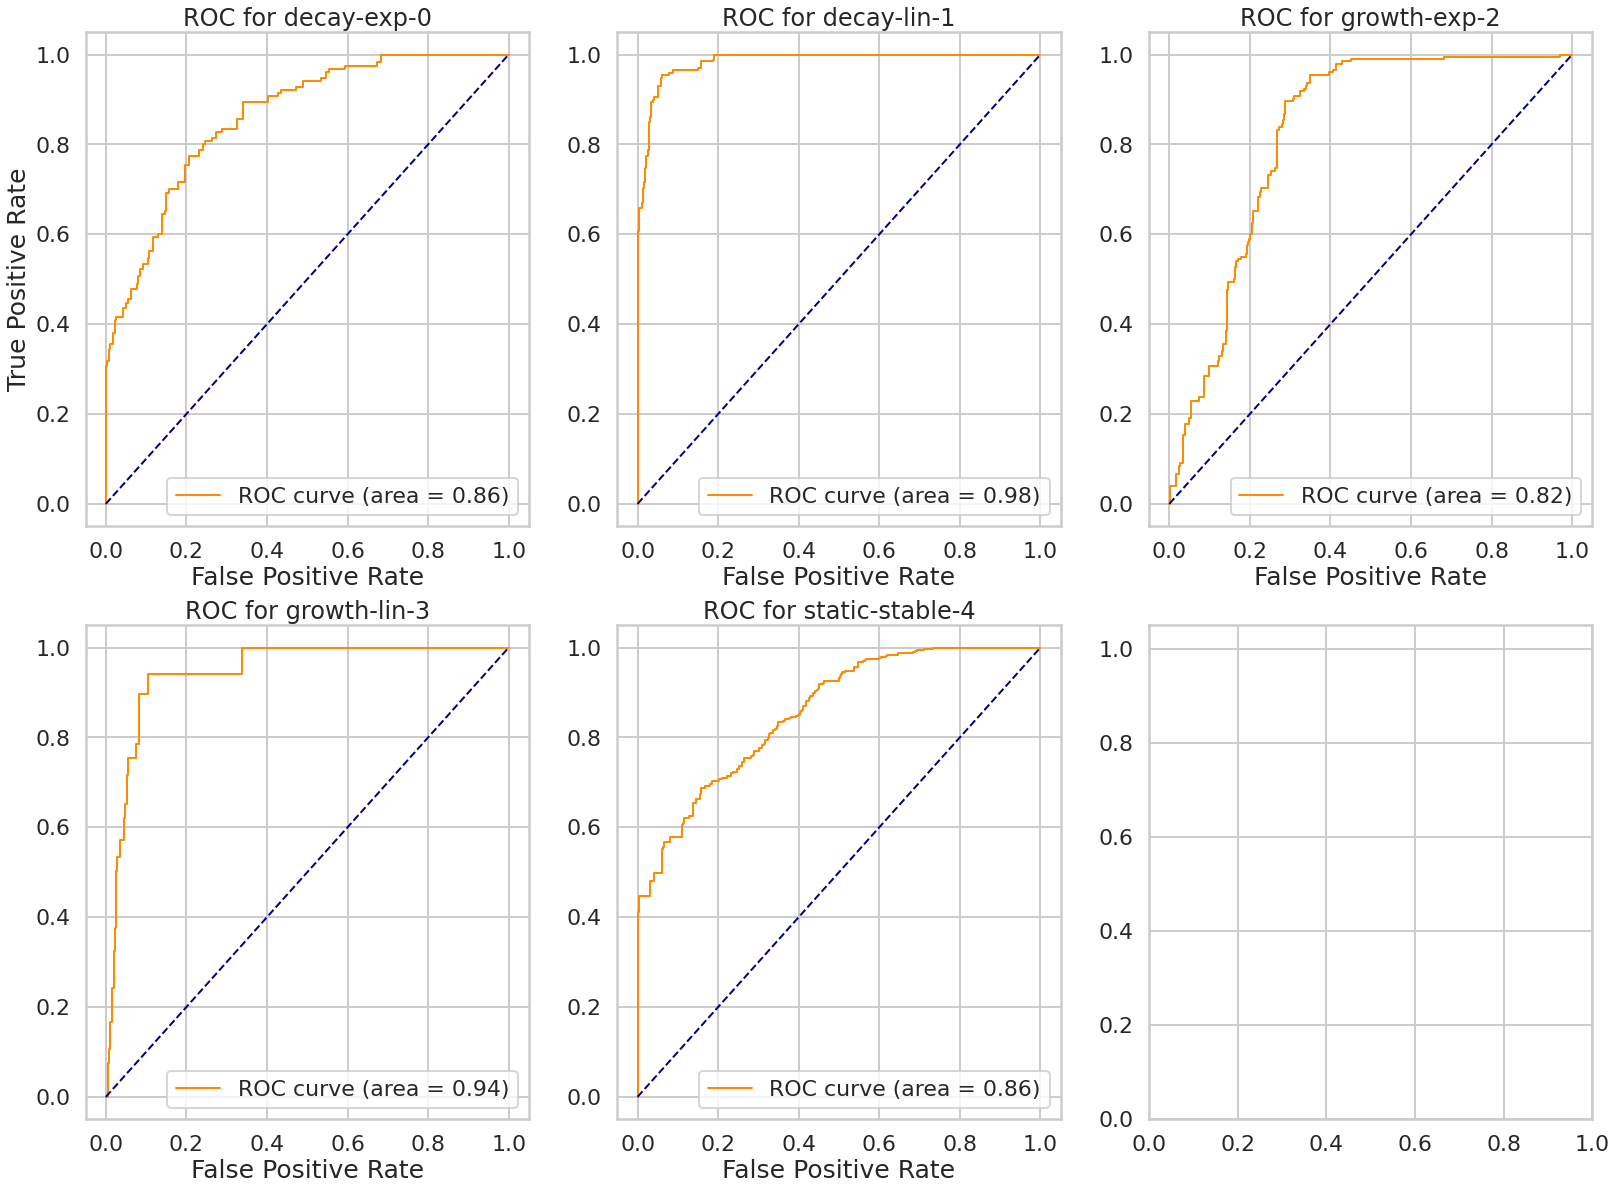



===Model for ros data===
best validation loss achieved: 0.7106097134549202
Test Acc: 0.5954477131200343
Test Ballance Acc: 0.6998797095133613
Test F1: 0.6446778035387608
One-vs-One ROC AUC scores:
0.887117 (macro),
0.859743 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.887117 (macro),
0.859743 (weighted by prevalence)


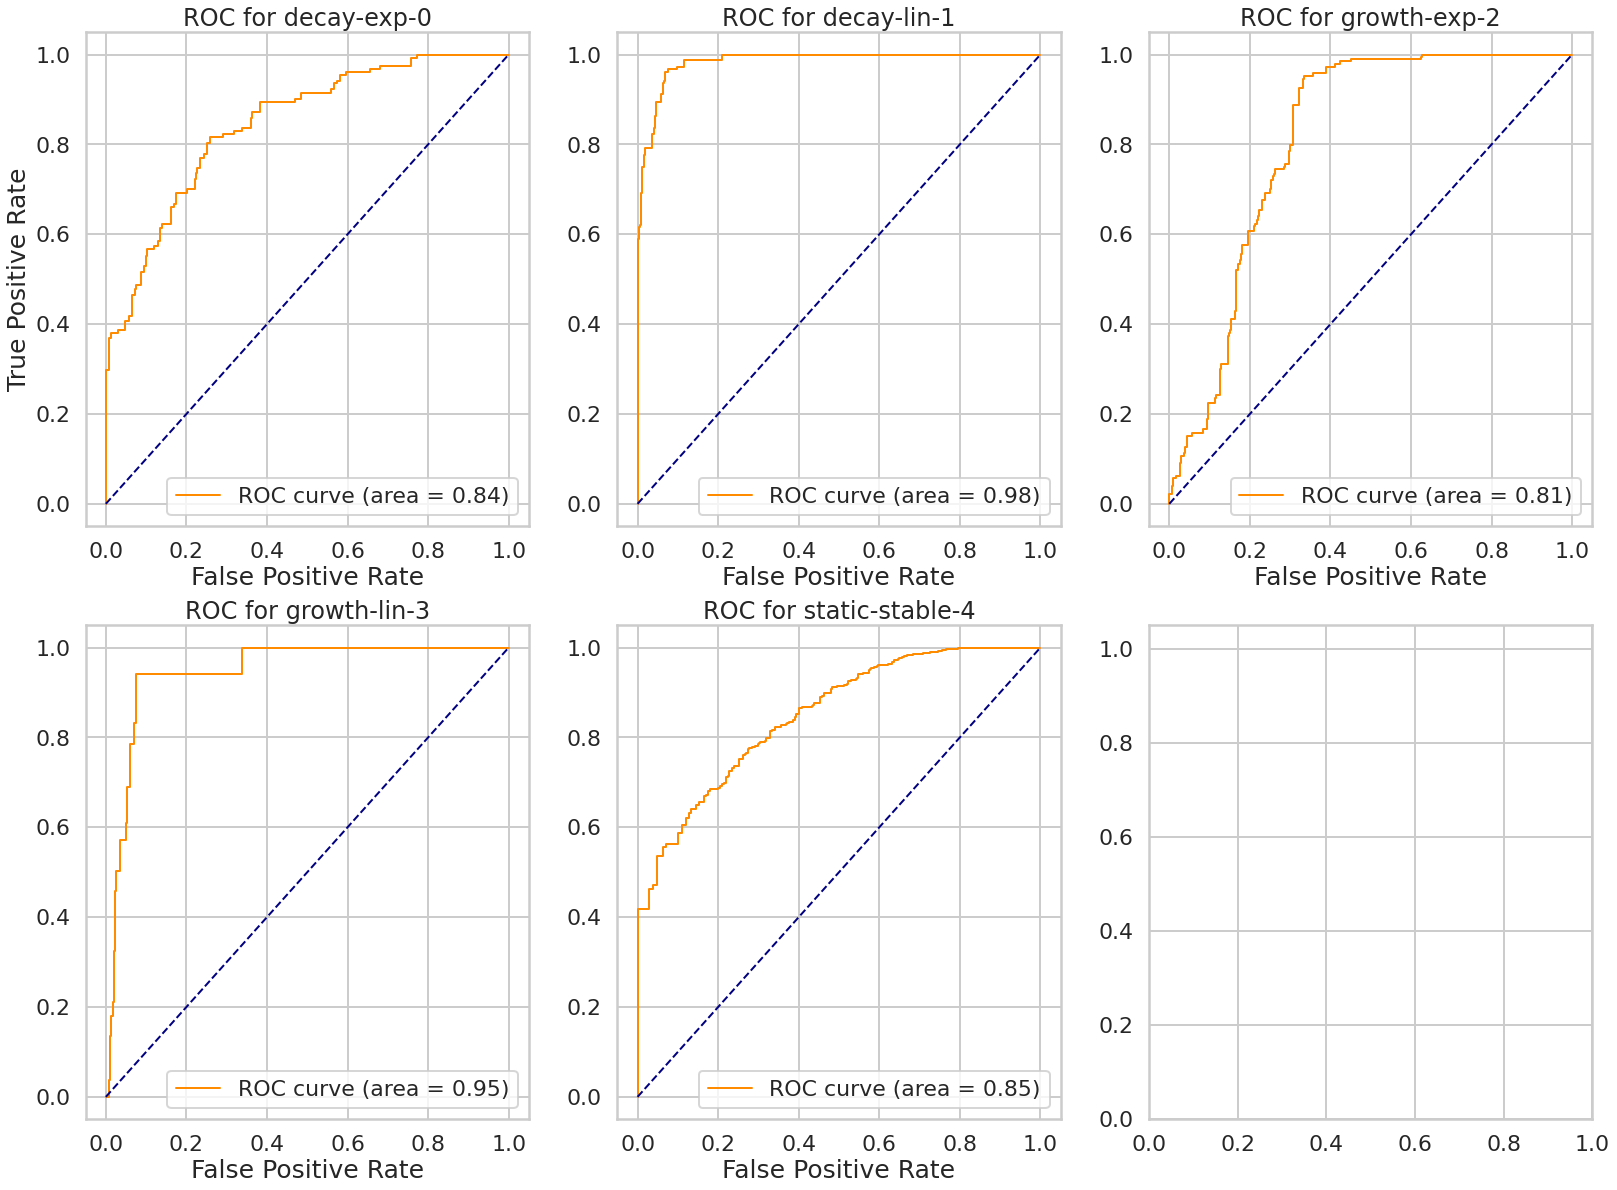



===Model for smotenc data===
best validation loss achieved: 0.6684141765933499
Test Acc: 0.5951792999785269
Test Ballance Acc: 0.6890295973078648
Test F1: 0.644682903275466
One-vs-One ROC AUC scores:
0.890915 (macro),
0.865069 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.890915 (macro),
0.865069 (weighted by prevalence)


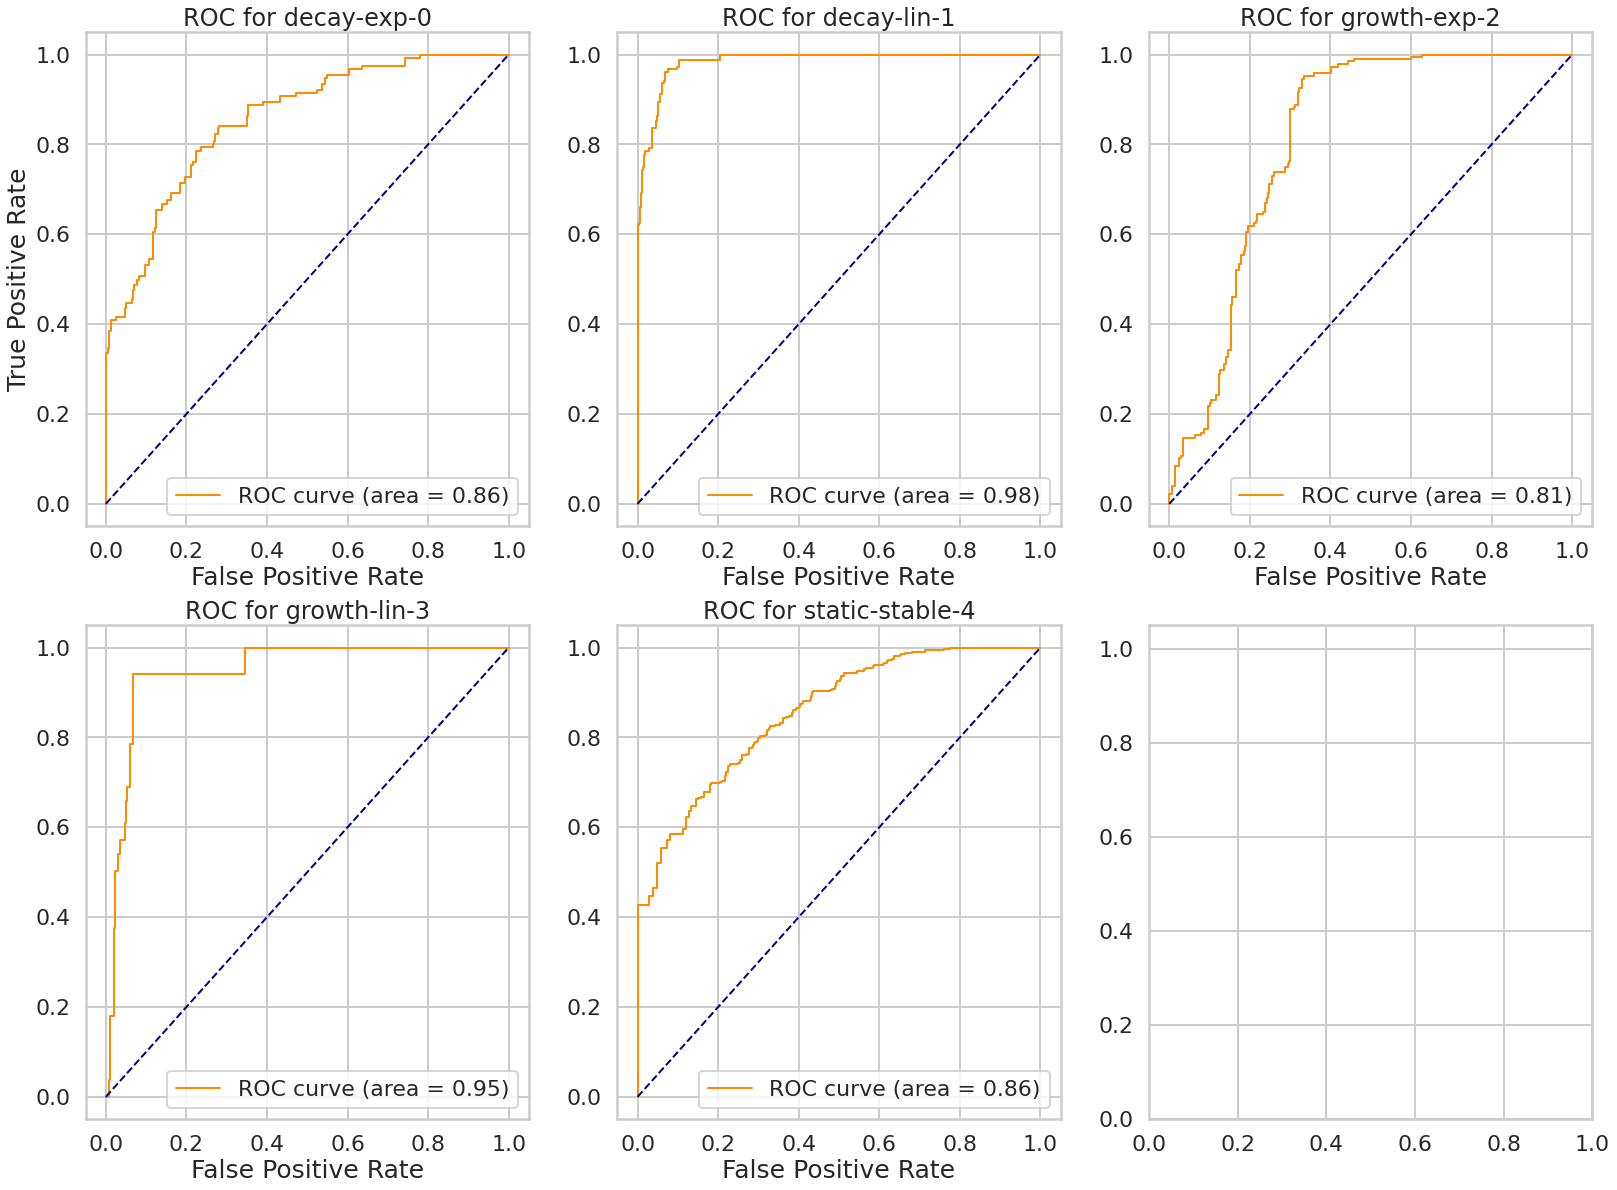

In [102]:
from base_model import Sfmx
from collections import defaultdict

sfmx_model_dict = dict()
sfmx_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    print(f"===Model for {sampler_name} data===")
    
    np.random.seed(0)
    model = Sfmx()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    sfmx_metric_dict['model'].append('softmax')
    sfmx_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, sfmx_metric_dict)
    sfmx_model_dict[sampler_name] = best_model
    print('\n')

In [103]:
sfmx_metric_df = pd.DataFrame.from_dict(sfmx_metric_dict)
sfmx_metric_df

,model,sampler_name,acc,balance_acc,f1_weighted,macro_auc_ovo,weighted_auc_ovo,macro_auc_ovr,weighted_auc_ovr
0,softmax,org,0.609405,0.697007,0.657705,0.894401,0.867647,0.894401,0.867647
1,softmax,ros,0.595448,0.699880,0.644678,0.887117,0.859743,0.887117,0.859743
2,softmax,smotenc,0.595179,0.689030,0.644683,0.890915,0.865069,0.890915,0.865069


### Coef visualization

In [115]:
def vis_coef(model):
    # print(model.coef_.shape)
    enc_label = list(map(int, sorted(y_test.unique())))
    # print(enc_label)

    coef_df = pd.DataFrame(model.coef_, index=enc_label, columns=input_feat)
    # print(coef_df.head())
    
    coef_ranked_dict = dict()
    fig, axs = plt.subplots(2, 3, figsize=(18, 20))
    for i, label in enumerate(enc_label):
        row, col = np.unravel_index(i, (2, 3))
        ax = axs[row][col]
        
        coef = coef_df.iloc[label]
        
        # Norm the coef
        min_coef, max_coef = min(abs(coef)), max(abs(coef))
        coef = (coef - min_coef) / (max_coef - min_coef)
        
        coef_ranked_dict[label] = sorted(zip(input_feat, coef), key=lambda x: abs(x[1]), reverse=True)
        g = sns.barplot(y=input_feat, x=coef, ax=ax)
        if i not in [0, 3]:
            g.set(yticklabels=[])
    plt.show()
    return coef_ranked_dict

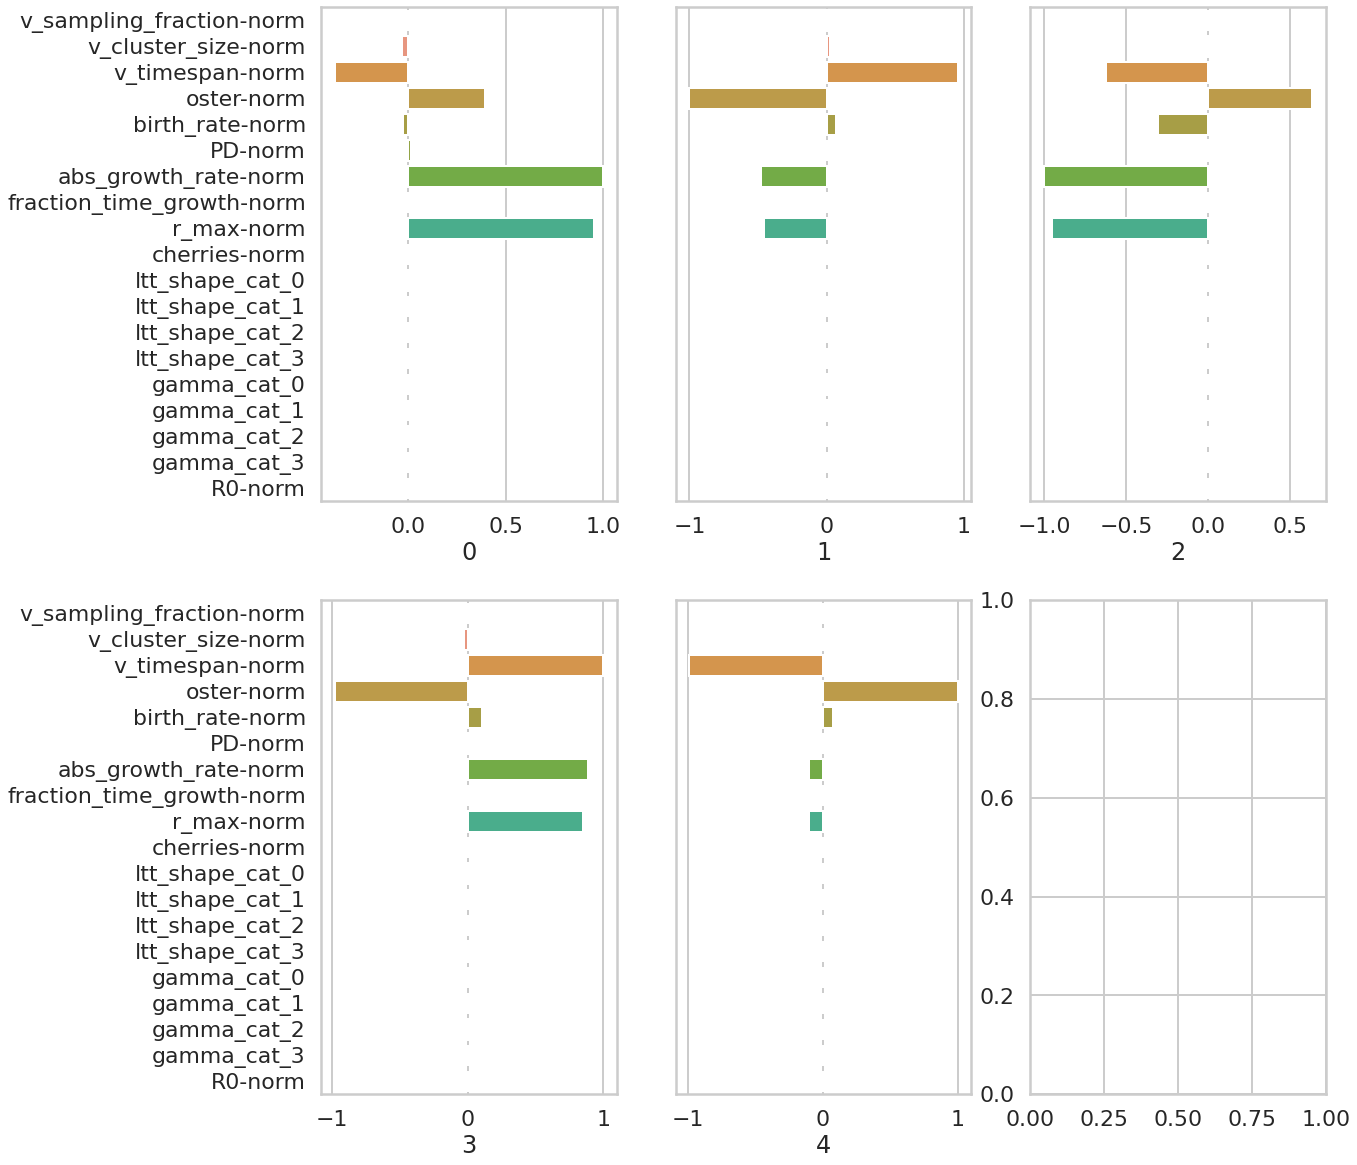

In [116]:
for sampler_type in train_data_dict.keys():
    if sampler_type == 'org':
        coef_dict = vis_coef(sfmx_model_dict[sampler_type])

### Save the model 

In [117]:
from joblib import dump, load

def save(model_dict, model_name):
    dump(model_dict, osp.join(model_folder, f'{model_name}.joblib'))

In [118]:
save(sfmx_model_dict, 'sfmx')

### Linear regression with one-vs-rest (OvR) scheme

===Model for org data===


/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


best validation loss achieved: 0.6256098750432109
Test Acc: 0.6395211509555507
Test Ballance Acc: 0.62532277519644
Test F1: 0.6882389833580987
One-vs-One ROC AUC scores:
0.801598 (macro),
0.810430 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.801598 (macro),
0.810430 (weighted by prevalence)


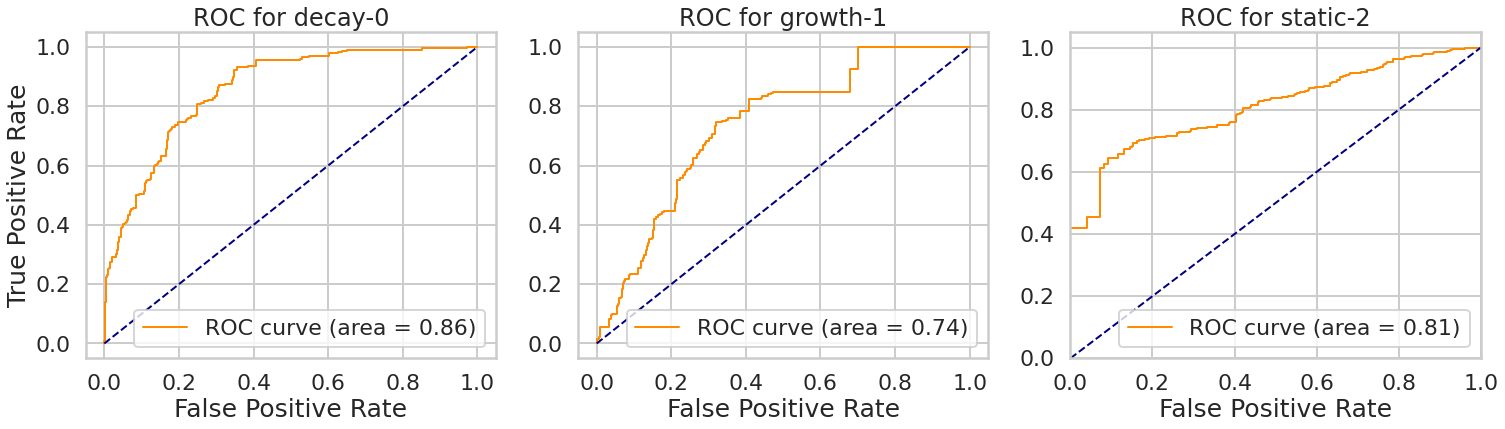



===Model for ros data===
best validation loss achieved: 0.6431775324656017
Test Acc: 0.6311466609405196
Test Ballance Acc: 0.6362640933460669
Test F1: 0.6808905870743812
One-vs-One ROC AUC scores:
0.787436 (macro),
0.795910 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.787436 (macro),
0.795910 (weighted by prevalence)


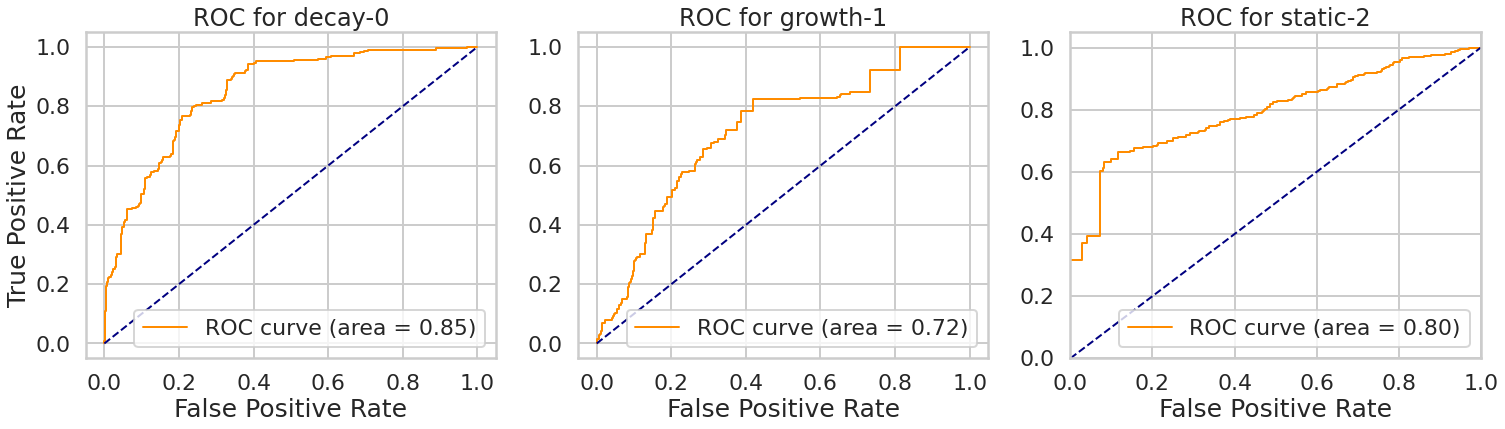



===Model for smotenc data===


/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not conv

best validation loss achieved: 0.6374707659131065
Test Acc: 0.6497208503328323
Test Ballance Acc: 0.6524246966651135
Test F1: 0.6990546352157151
One-vs-One ROC AUC scores:
0.791572 (macro),
0.802323 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.791572 (macro),
0.802323 (weighted by prevalence)


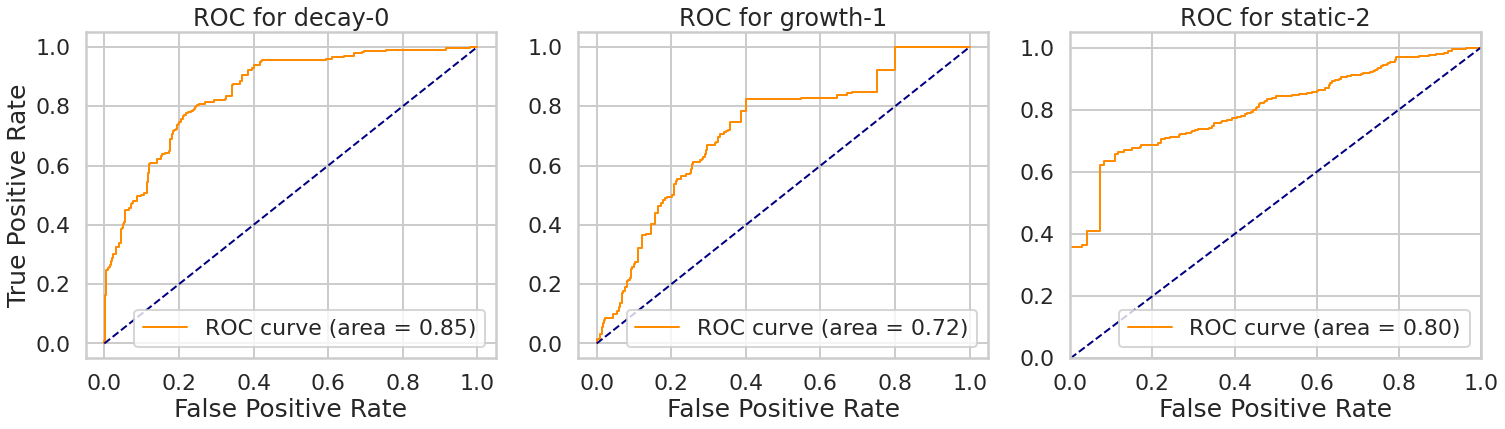

In [34]:
# from base_model import Sfmx

sfmx_ovr_model_dict = dict()
sfmx_ovr_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    print(f"===Model for {sampler_name} data===")
    
    np.random.seed(0)
    model = Sfmx(multi_class='ovr')
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_ovr_metric_dict)
    sfmx_ovr_metric_dict['model'].append('softmax_ovr')
    sfmx_ovr_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, sfmx_ovr_metric_dict)
    sfmx_ovr_model_dict[sampler_name] = best_model
    print('\n')

In [35]:
sfmx_ovr_metric_df = pd.DataFrame.from_dict(sfmx_metric_dict)
sfmx_ovr_metric_df

,model,sampler_name,acc,balance_acc,f1_weighted,macro_auc_ovo,weighted_auc_ovo,macro_auc_ovr,weighted_auc_ovr
0,softmax,org,0.632918,0.640621,0.682314,0.796091,0.806713,0.796091,0.806713
1,softmax,ros,0.624651,0.635466,0.672717,0.791048,0.800084,0.791048,0.800084
2,softmax,smotenc,0.633348,0.644037,0.681116,0.794745,0.803083,0.794745,0.803083


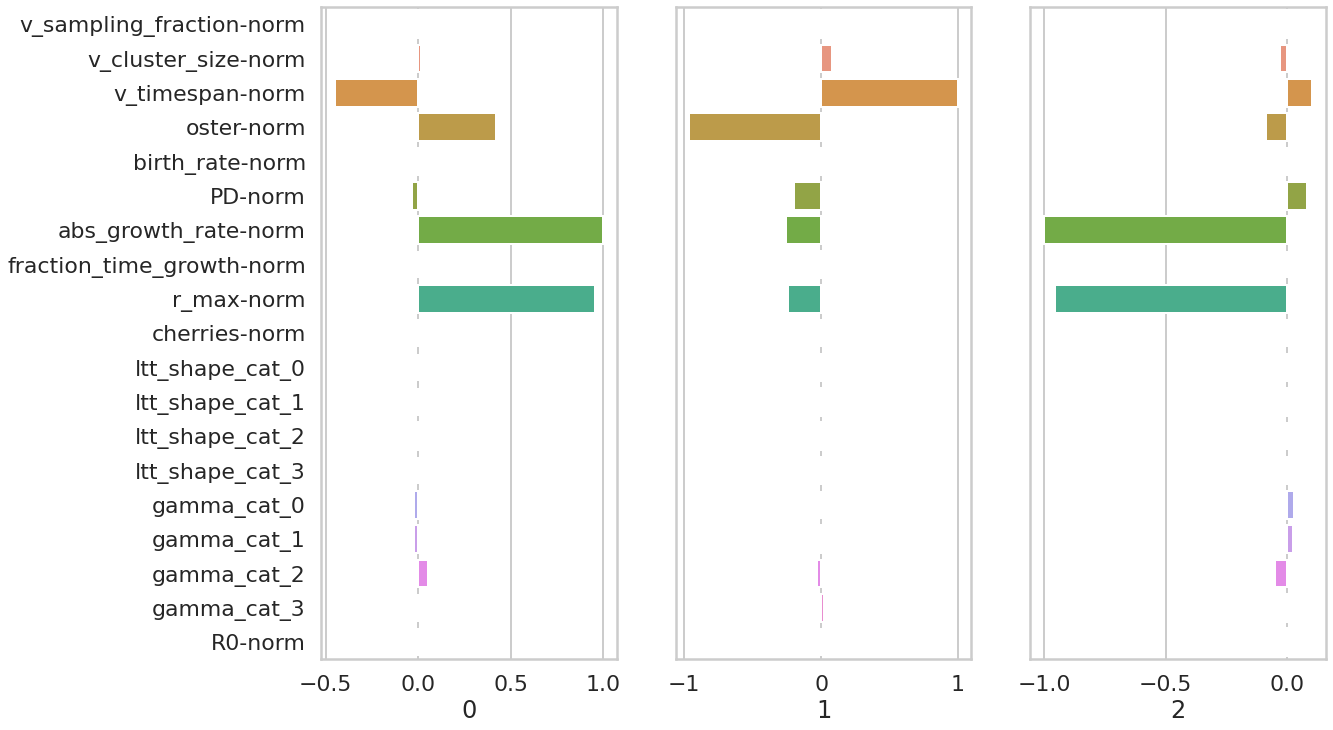

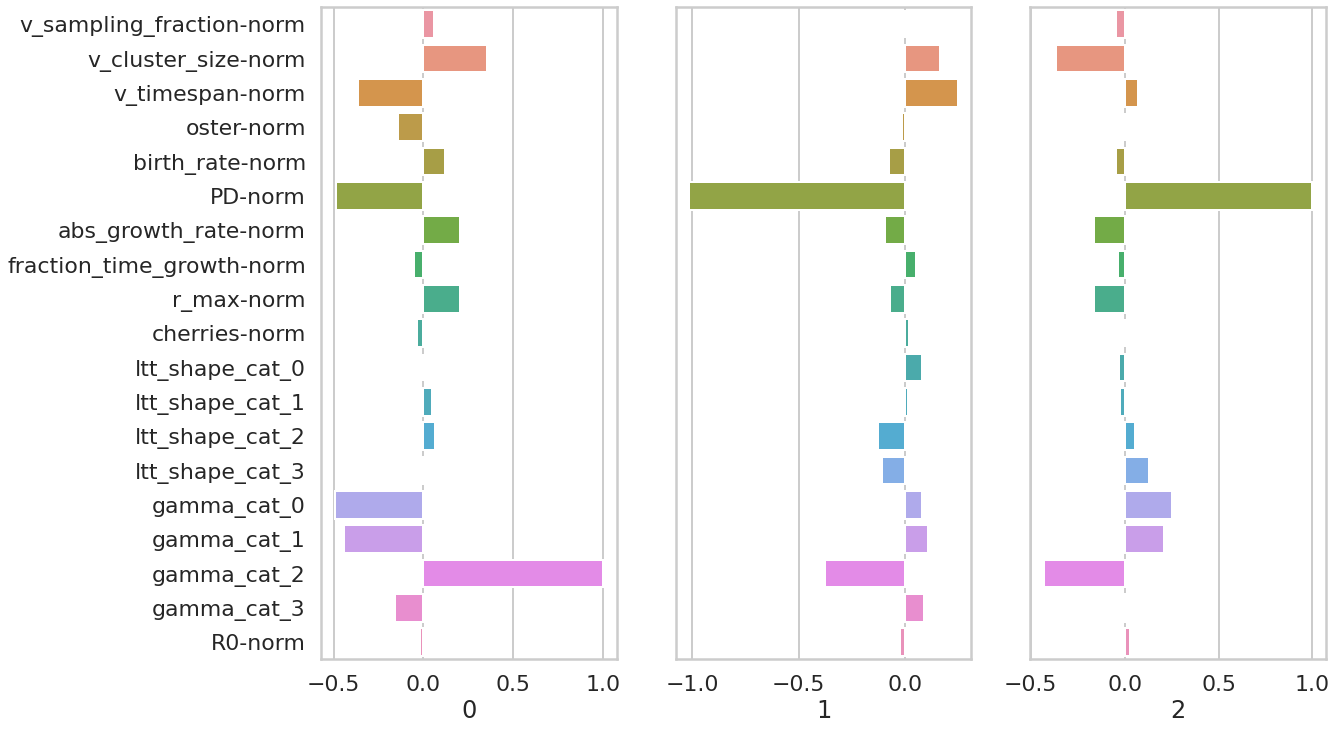

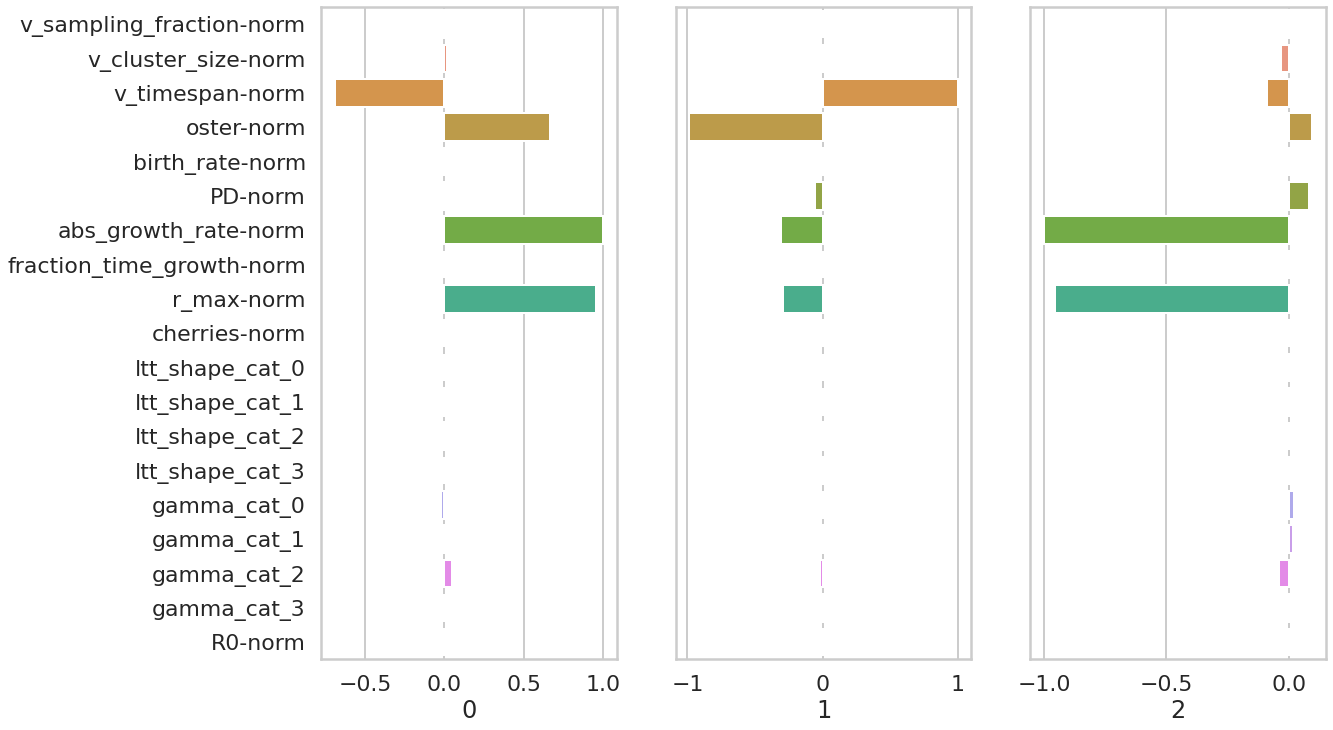

In [36]:
for sampler_type in train_data_dict.keys():
    coef_dict = vis_coef(sfmx_ovr_model_dict[sampler_type])

In [37]:
save(sfmx_model_dict, 'sfmx_ovr')

### Random Forest

===Model for org data===
best validation loss achieved: 0.6268478137965229
Test Acc: 0.622933218810393
Test Ballance Acc: 0.6731621095975655
Test F1: 0.6665140916258365
One-vs-One ROC AUC scores:
0.894163 (macro),
0.866014 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.894163 (macro),
0.866014 (weighted by prevalence)


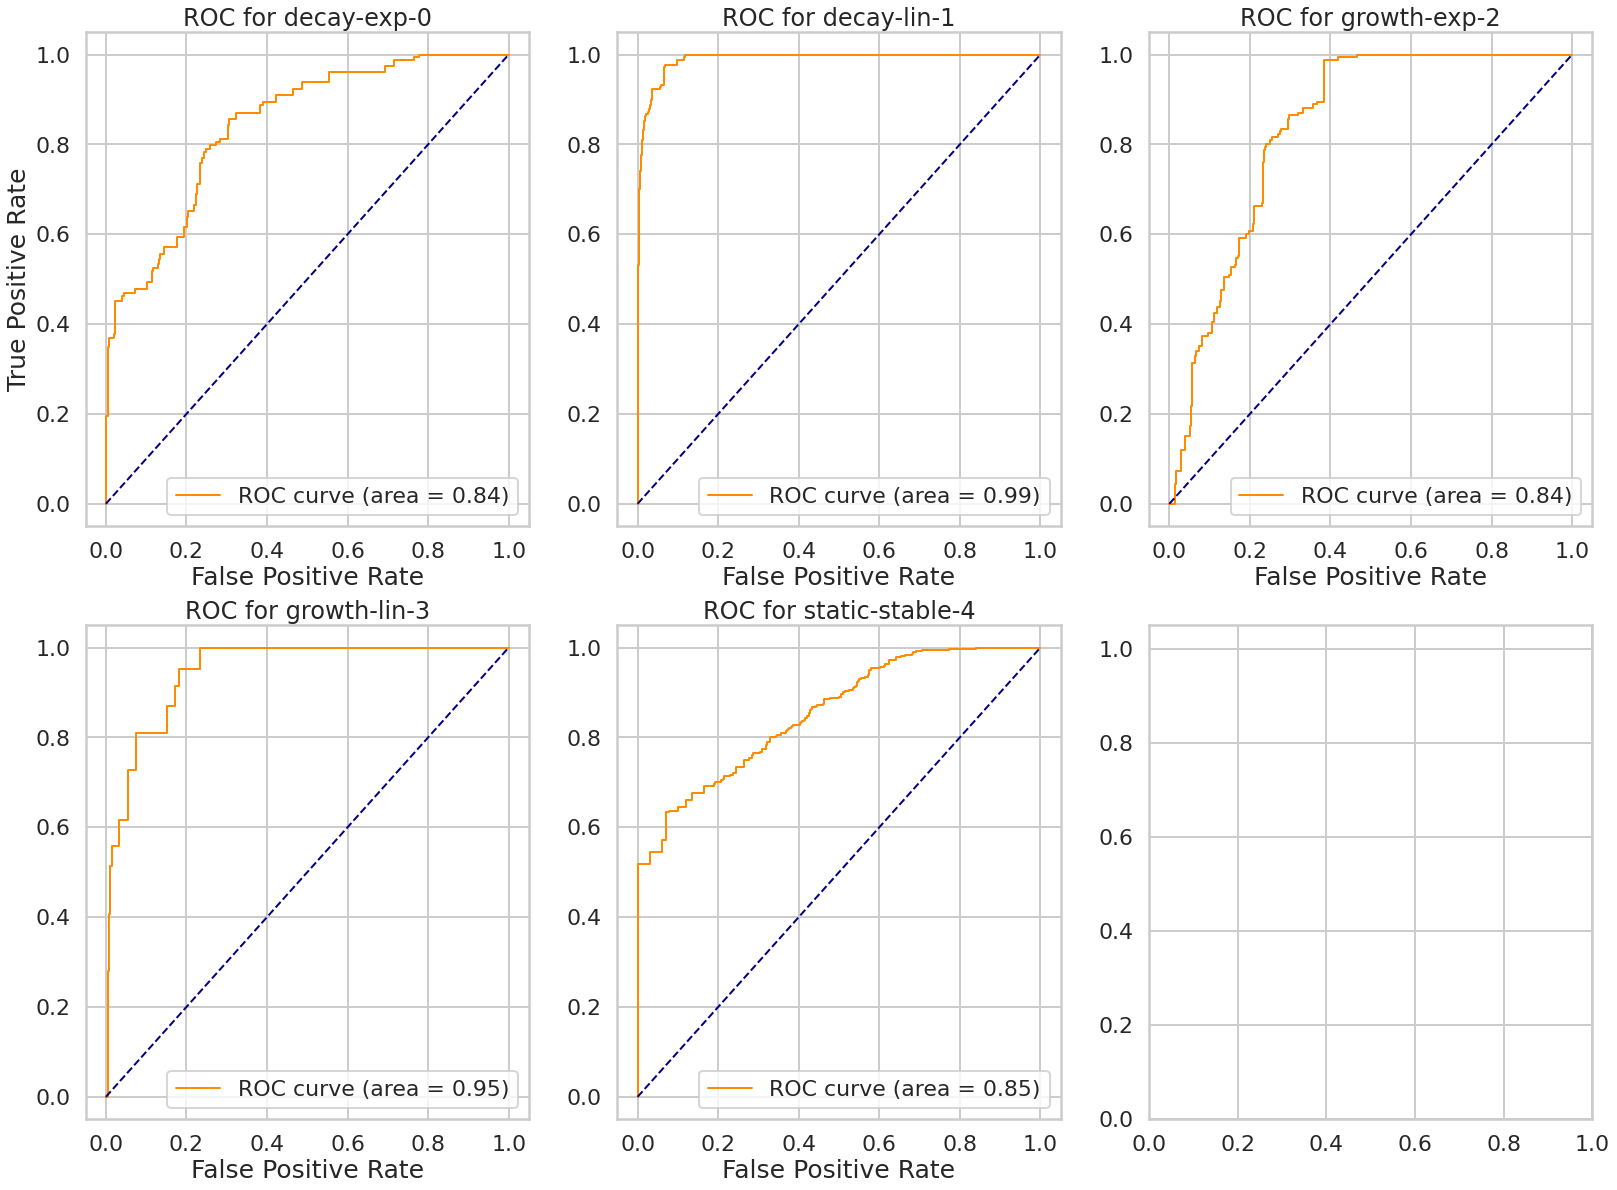

In [119]:
from base_model import RF
from collections import defaultdict

rf_model_dict = dict()
rf_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    if sampler_name != 'org':
        continue
    np.random.seed(0)
    print(f"===Model for {sampler_name} data===")
    
    model = RF()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    rf_metric_dict['model'].append('rf')
    rf_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, rf_metric_dict)
    rf_model_dict[sampler_name] = best_model
    print('\n')

### Feature Importance

In [120]:
def cal_feat_impt(model):
    fig, axs = plt.subplots(figsize=(18, 12))

    coef_ranked_dict = dict()

    # Gini importance: The higher, the more important the feature. 
    # The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
    coef = model.feature_importances_

    coef_ranked = sorted(zip(input_feat, coef), key=lambda x: abs(x[1]), reverse=True)
    
    sns.barplot(y=input_feat, x=coef)
    print(coef_ranked)

In [121]:
for sampler_type in train_data_dict.keys():
    if sampler_name != 'org':
        continue
    coef_dict = cal_feat_impt(rf_model_dict[sampler_type])

In [122]:
save(rf_model_dict, 'rf')

### Analyze the mis-classcification 

In [123]:
def get_misclass(y_true, y_pred):
    mis_id_dict = defaultdict(dict)
    mis_ids = y_true != y_pred
    print(f'Total Mis: {sum(mis_ids)}, ({100 * sum(mis_ids) / len(y_true):.3f}%)')
    
    print(label_map)
    for i in range(len(label_map)):
        label_ids = y_true == i
        sub_mis_id_dict = defaultdict(list)
        
        for idx, (label_id, mis_id) in enumerate(zip(label_ids, mis_ids)):
            if label_id and mis_id:
                sub_mis_id_dict[y_pred[idx]].append(idx)
        
        n_mis = sum([len(mis_lst) for mis_lst in sub_mis_id_dict.values()])
        n_sample = sum(label_ids)
        
        print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')
        for mis_label, mis_lst in sub_mis_id_dict.items():
            print(f'\t{mis_label}: {len(mis_lst)}')
        
        mis_id_dict[i] = sub_mis_id_dict
    return mis_id_dict

In [124]:
rf_model = rf_model_dict['org']
y_test_pred = rf_model.predict(x_test)
y_test_predscore = rf_model.predict_proba(x_test)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)

Total Mis: 7024, (37.707%)
{0: 'decay', 1: 'growth', 2: 'static'}
Mis-classified of decay: 694/1289, (53.840%)
	2: 325
	3: 321
	1: 48
Mis-classified of growth: 58/1762, (3.292%)
	2: 58
Mis-classified of static: 435/1677, (25.939%)
	1: 96
	3: 23
	0: 17
	4: 299


In [125]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_arr, y_test_pred)
conf_mat

array([[ 595,   48,  325,  321,    0],
       [   0, 1704,   58,    0,    0],
       [  17,   96, 1242,   23,  299],
       [  11,    0,  100,  179,    0],
       [ 795,  941, 3534,  456, 7884]])

In [130]:
extend_rvs_label_map

{0: 'decay-exp',
 1: 'decay-lin',
 2: 'growth-exp',
 3: 'growth-lin',
 4: 'static-stable'}

[None, None, None, None, None, None, None, None, None, None]

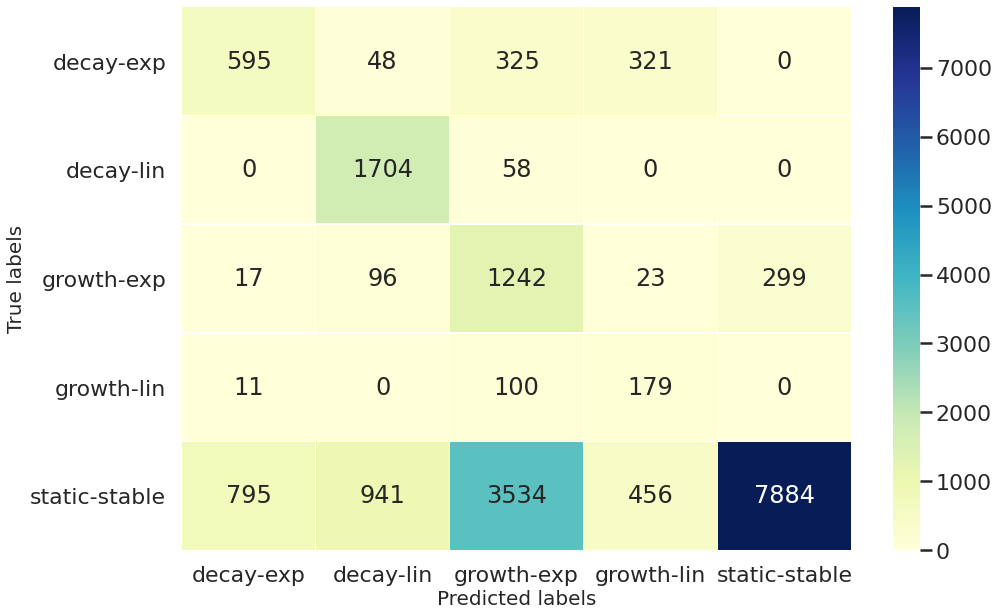

In [132]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", ax=ax)
ax.set_ylabel('True labels', fontsize=20)
ax.set_xlabel('Predicted labels', fontsize=20)

ax.set_xticklabels(list(extend_rvs_label_map.values()))
ax.set_yticklabels(list(extend_rvs_label_map.values()))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

In [133]:
# Merget the test data and prediction
y_test_true_df = pd.DataFrame({'true': y_test})
y_test_pred_df = pd.DataFrame({'pred': y_test_pred})
test_pred_df = pd.concat([x_test, y_test_true_df, y_test_pred_df], axis=1)
test_pred_df.to_csv(osp.join(model_folder, 'rf_org_pred.csv'), index=False)

test_pred_df.tail()

,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,...,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,R0-norm,true,pred
18623,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,4,1
18624,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,4,1
18625,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,4,1
18626,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,4,1
18627,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,4,1


In [134]:
legend_info

{0: 'decay-exp',
 1: 'decay-lin',
 2: 'growth-exp',
 3: 'growth-lin',
 4: 'static-stable'}

In [ ]:
pred_label_map = deepcopy(label_map)
extend_legend_info = deepcopy(legend_info)

rvs_pred_label_map = defaultdict(dict)
new_label = len(label_map)

for label in range(n_classes):
    for mis_pred in range(n_classes):
        if label != mis_pred:
            rvs_pred_label_map[label][mis_pred] = new_label
            pred_label_map[new_label] = {'true': label, 'pred': mis_pred}
            extend_legend_info[new_label] = f'{label_map[label]}->{label_map[mis_pred]}'
            new_label += 1
pred_label_map

In [50]:
extend_legend_info

{0: 'decay',
 1: 'growth',
 2: 'static',
 3: 'decay->growth',
 4: 'decay->static',
 5: 'growth->decay',
 6: 'growth->static',
 7: 'static->decay',
 8: 'static->growth'}

In [51]:
extend_y_test_pred = []

for y_true, y_pred in zip(y_test, y_test_pred):
    if y_true == y_pred:
        extend_y_test_pred.append(y_true)
    else:
        extend_label = rvs_pred_label_map[y_true][y_pred]
        extend_y_test_pred.append(extend_label)
print(extend_y_test_pred[-10:])

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


Not saved! The t-SNE feature file has already exited. /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/org/test_pred.npy
   label   t-SNE-1     t-SNE-2
0    2.0  7.372206  101.837090
1    2.0  7.372206  101.837090
2    2.0  7.065592  100.003075
3    2.0  7.065592  100.003075
4    2.0  7.065592  100.003075
('8.0', '7.0', '6.0', '5.0', '4.0', '3.0', '2.0', '1.0', '0.0')


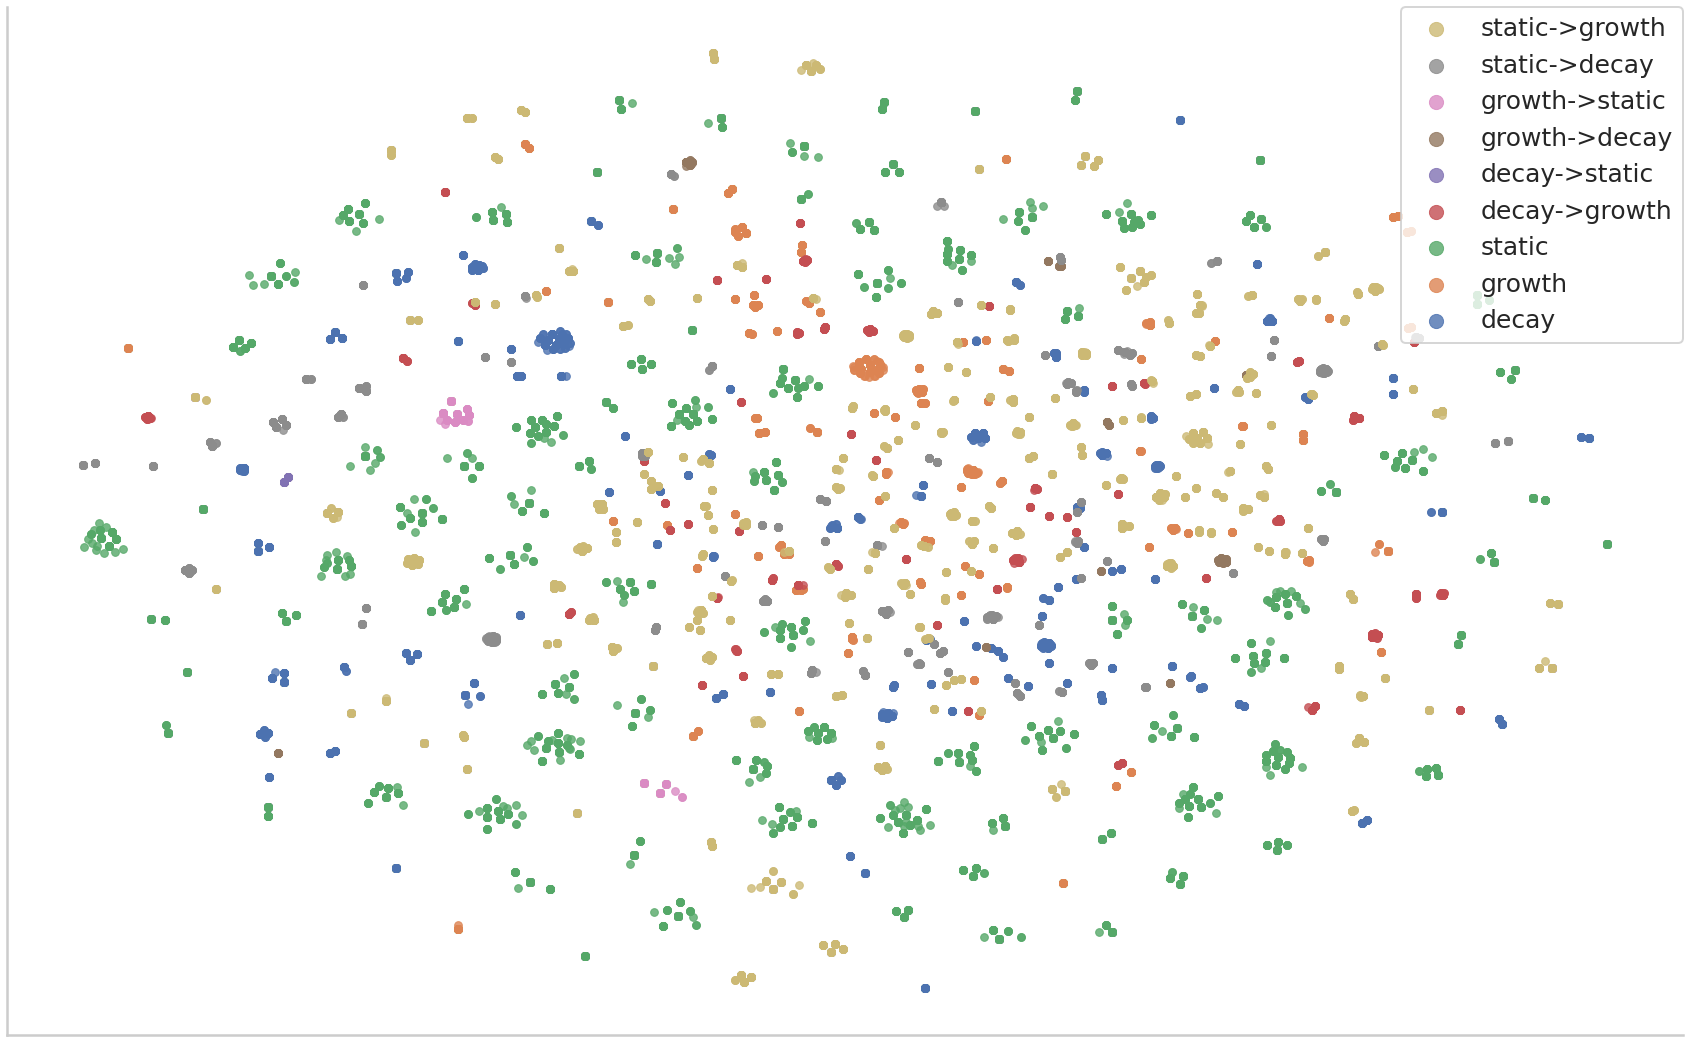

Not saved! The figure /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/org/test_pred.png.png has already existed.


In [52]:
aly_test_tsne = AlyTSNE(feat=x_test.values, label=extend_y_test_pred, subset='test_pred', save_folder=f'{tsne_folder}/org')
aly_test_tsne.generate_tsne(overwrite=False)
aly_test_tsne.plot(legend_info=extend_legend_info)

### XGBoost

===Model for org data===
best validation loss achieved: 0.7929507405958744
Test Acc: 0.7970796650203994
Test Ballance Acc: 0.358809898186225
Test F1: 0.7348994631918734
One-vs-One ROC AUC scores:
0.883418 (macro),
0.867360 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.883418 (macro),
0.867360 (weighted by prevalence)


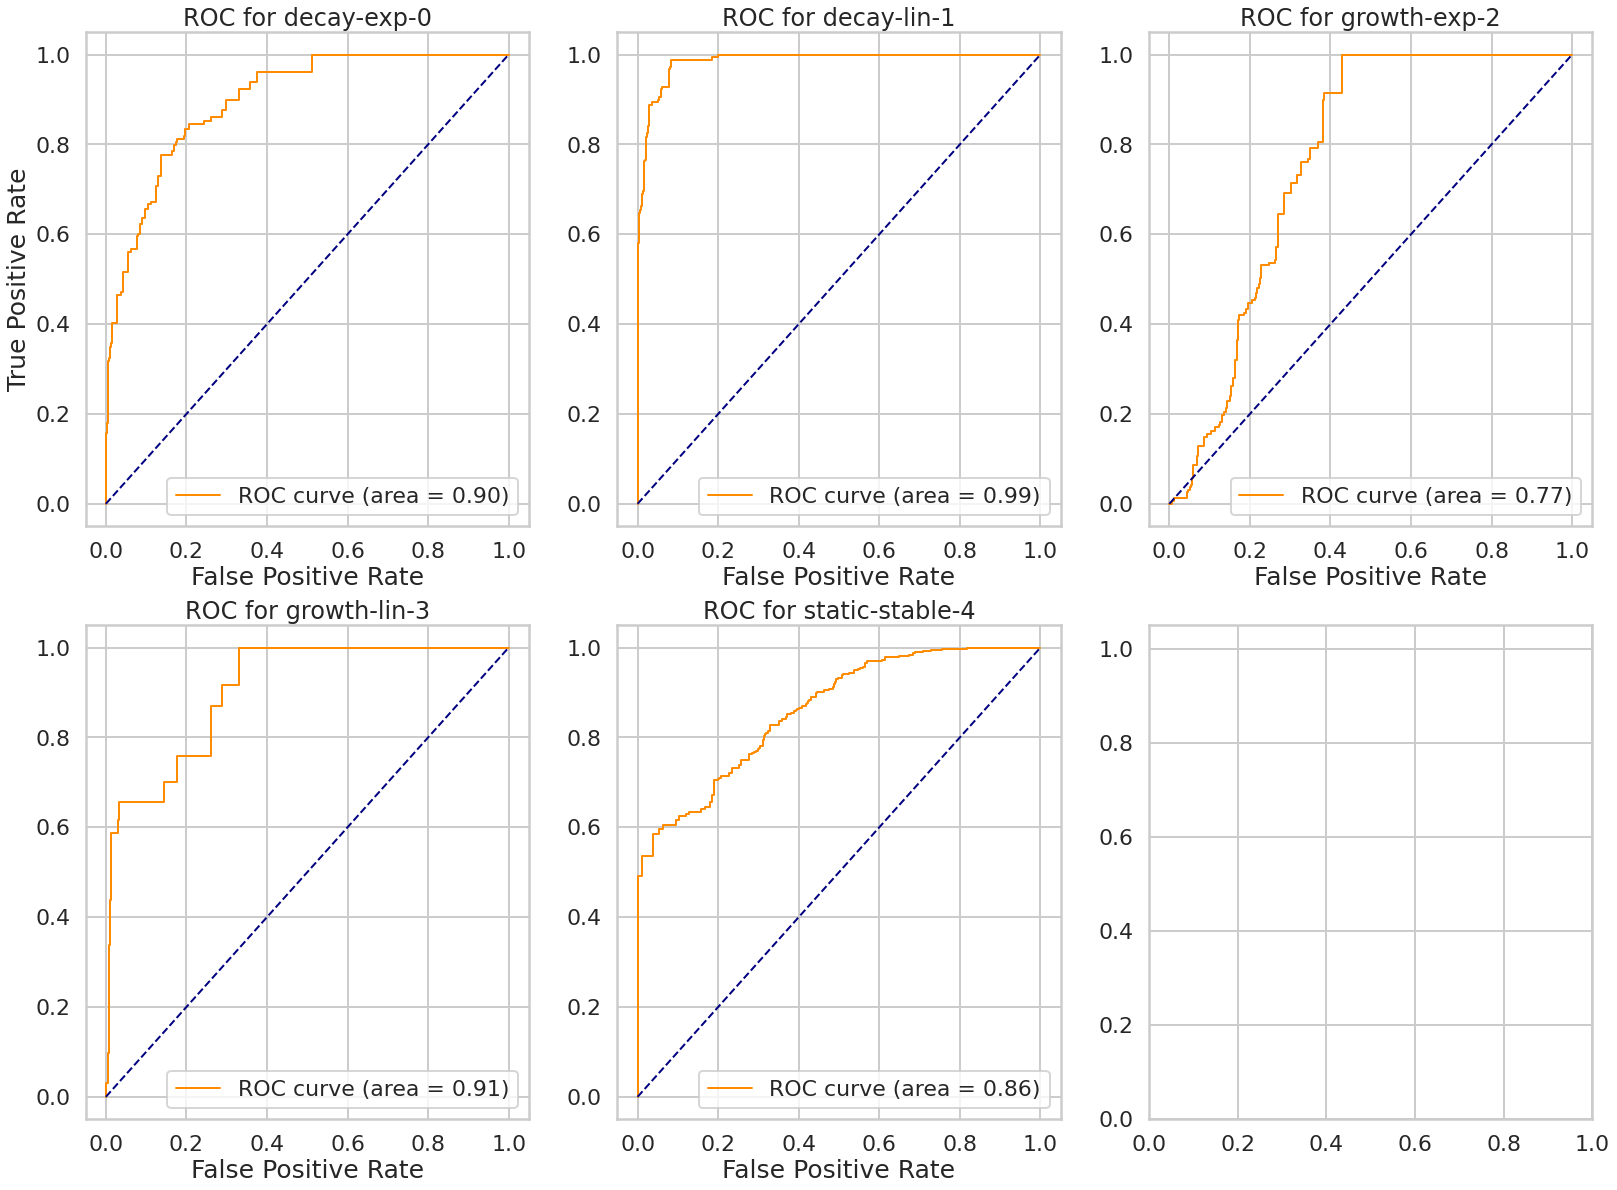

In [136]:
from base_model import XGB

xgb_model_dict = dict()
xgb_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    if sampler_name != 'org':
        continue
    np.random.seed(0)
    print(f"===Model for {sampler_name} data===")
    
    model = XGB()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    xgb_metric_dict['model'].append('rf')
    xgb_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, xgb_metric_dict)
    xgb_model_dict[sampler_name] = best_model
    print('\n')

In [137]:
for sampler_type in train_data_dict.keys():
    if sampler_name != 'org':
        continue
    coef_dict = cal_feat_impt(xgb_model_dict[sampler_type])

In [138]:
from xgboost import plot_importance, plot_tree

def plot_impt(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 20))

    # Feature importance type: 
    # "gain" is the average gain of splits which use the feature
    # "weight" is the number of times a feature appears in a tree

    for i, impt_type in enumerate(['gain', 'weight']): 
        ax = plot_importance(model, importance_type=impt_type, ax=axs[i], show_values=False)
        ax.set_title(f'Feature importance: {impt_type}')
    plt.show()

In [139]:
for sampler_type in train_data_dict.keys():
    if sampler_name != 'org':
        continue
    plot_impt(xgb_model_dict[sampler_type])
    break

In [140]:
save(xgb_metric_dict, 'xgb')